# This Notebook creates some plots and analyses my_databse

**Channel 1-4**: "old cable", broke in middle

**Channel 5-8**: EGRT cable, installed for an EGRT. Could not installed until bottom of shaft. Some cable lays at surface.



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("seaborn")
import numpy as np
import matplotlib.dates as mdates
from scipy import optimize
import matplotlib.patches as patches
from collections import defaultdict
from datetime import timedelta
from datetime import datetime
import pickle
from ipywidgets import interact
import ipywidgets as widgets
from copy import deepcopy#, copy
import statistics
from random import randrange

from my_func_mvw.functions_import_my_database import import_my_database_pickle, import_my_database_csv

# MORGEN
# avearagefirst berechnung anpassen, sodass nicht alles processing nochmal gemacht werden muss.
# evntl processing vor watertank shift machen
#
#chanel 5 und 6 schein bei der Länge noch etwas nicht optimal zu sein, wassertank positionen werden
# zwar genau gemittelt aber ich denke dazwischen ist noch etwas verschoben

# !!!!!!!!Ich muss einen Test machen indem ich die Temp vom Kabel ändere!!!!!!!!!!!!!!!!!!!!!!!!!!
    # für abkühlung des wassertanks eiswürfel kaufen 10 kg oder so und in tank rein. Am besten irgendwie an Boden in Box fixieren, damit es irgendwie gleichmäßig abkühlt und nicht eiswürfel direkt am kabel liegen

# watertank positionen 56 und 78 trennen, spleißen kann unterschiedlich viel Kabel verbrauchen?
    # dann müsste ich alle seperat betrachten, wegen den pigtails

############To DO#######################
# Wenn ich die Wassertankposition 100 % final bestimmt habe, auch gucken, dass die Differenzen zwischen den CHanneln 5-6 und 7-8 (siehe Plot), keine starken peaks haben. Starke peaks deuten denke ich darauf hin, dass nicht genau die gleichen Positionen geavearaged werden. Vorallem am Übergang zum Wasser oder in Schacht rein zu sehen
#
# Finale Temperatur (mean channels) mit Fehlerabschätzung vom EGRT Kabel speichern
# Channel 7 und 8 mit zusätzlicher Wassertank position nach Spleißkasten verschieben
#   das muss auch vor dem flippen gemacht werden!
#
# Wasserstant über die Zeit anhand von Temperatursprung beobachten, hat Daniel das schon gemacht?
#   plot erstellen, mit x-AchseZeit y-Achse Wasserstand

print("Some Version information of the imported packages")
print(f"pandas version: {pd.__version__}")
print(f"pickle version: {pickle.format_version}")

Some Version information of the imported packages
pandas version: 1.2.3
pickle version: 4.0


In [2]:
%%time
# Wall time: 1min 56s

# # Load csv data
path_to_my_database = r"..\Alsdorf\Daten\my_database"
# data_2019 = import_my_database_csv(2019, path_to_my_database + r"\csv")
# data_2020 = import_my_database_csv(2020, path_to_my_database + r"\csv")
# data_2021 = import_my_database_csv(2021, path_to_my_database + r"\csv")

Wall time: 1 ms


In [3]:
%%time
# Wall time: 7.64 s

# Load pickle Data
path_to_my_database_pickle = path_to_my_database + r"\pickle"
data_2021=import_my_database_pickle(2021, path_to_my_database_pickle)
data_2020=import_my_database_pickle(2020, path_to_my_database_pickle)
data_2019=import_my_database_pickle(2019, path_to_my_database_pickle)

Wall time: 8.26 s


In [4]:
%%time
#Wall time: 19.7 s
# Merge the different year dics into one
def merge_data_year(list_data_years):
    """input the different year dics as a list"""
    data = {}

    for data_20xx in list_data_years:
        for channel in data_20xx.keys():

            if channel in data.keys():
                data[channel] = pd.concat([data[channel], data_20xx[channel]], axis = 0)

            else: # channel not in data dic
                data[channel] = data_20xx[channel]

    #eventle noch sort index machen; the seperate years are already sorted by index during saving
    return data

data_all = merge_data_year([data_2019, data_2020, data_2021])

Wall time: 15.1 s


In [5]:
def find_nearest_date(base_date_name,date_index):
    """find the nearest date to base_date_name in date_index
    base_date_name: put in as str or Timestamp, I use a format like this: '2021-06-07 18:52:45'
    date_index: index of a dataframe, which contains dates
    returns:
    date_name: str
    date_iloc: position of date_name in date_index
    """
    date_iloc=date_index.get_loc(base_date_name,method="nearest")
    date_name=str(date_index[date_iloc])
    return date_name, date_iloc

In [6]:
def import_t_logger(path_to_data_Tlogger, filename_Tlogger):
    """"""
    df_Tlogger = pd.read_csv(path_to_data_Tlogger + "\\" + filename_Tlogger, sep=";", usecols=[1,2,3,4], names=["Date","Time","Channel1-Watertank","Channel2-Air"])
    DateTime=df_Tlogger["Date"] + " " + df_Tlogger["Time"]
    df_Tlogger.index =pd.to_datetime(DateTime, format=("%d.%m.%y  %H:%M:%S"))
    df_Tlogger.index.names = ['Date']
    df_Tlogger = df_Tlogger.drop(df_Tlogger.columns[0:2],axis=1) # drop the two columns which are now used for index

    # # Drop data from T- Logger when I was there, because measurent stopps can be a bit tricky to handly in this script
    # index_for_drop=df_Tlogger.index[:400]
    # index_for_drop2=df_Tlogger.index[-300:]
    # df_Tlogger=df_Tlogger.drop(index_for_drop)
    # df_Tlogger=df_Tlogger.drop(index_for_drop2)
    return df_Tlogger

In [7]:
# Load data T-logger
path_to_data_Tlogger = r"..\Alsdorf\Daten\T-logger"
######## Add new, when downloading new data from t_logger###################
filename_Tlogger_0 = "20210608\_adc_START_07.06.2021-12_11_40_daten.txt" 
filename_Tlogger_1 = "20210702\_adc_START_08.06.2021-13_21_47_daten.txt"

df_Tlogger_0 = import_t_logger(path_to_data_Tlogger, filename_Tlogger_0)
df_Tlogger_1 = import_t_logger(path_to_data_Tlogger, filename_Tlogger_1)
df_Tlogger = pd.concat([df_Tlogger_0,df_Tlogger_1])
################################################################################

#Simple Moving Avearage
#https://towardsdatascience.com/moving-averages-in-python-16170e20f6c nice explanation
df_Tlogger["Channel1-rolling_mean"]=df_Tlogger["Channel1-Watertank"].rolling(5,min_periods=1).mean() # 15 min window time
df_Tlogger

Channel1-Watertank  Channel2-Air  Channel1-rolling_mean
Date                                                                        
2021-06-07 12:12:40           24.948476     25.819904              24.948476
2021-06-07 12:13:40           25.026853     25.443956              24.987665
2021-06-07 12:14:40           24.888809     25.165027              24.954713
2021-06-07 12:15:40           25.011371     24.926351              24.968877
2021-06-07 12:16:40           25.014596     24.753213              24.978021
...                                 ...           ...                    ...
2021-07-02 11:57:18           24.832365     22.912437              24.881841
2021-07-02 12:00:18           24.803981     22.864185              24.856103
2021-07-02 12:03:18           24.841718     22.796581              24.844814
2021-07-02 12:06:18           24.854297     22.648990              24.838557
2021-07-02 12:09:18           24.876230     22.544746              24.841718

[13001 rows x 3 columns]

In [8]:
def temp_watertank_func(x):
    """returns Temperature of Watertank at given time x, of the moving avearage values
    this is not really a matheamtical function, but I named it like this when I was using a polynomial function
    """
    # find nearest date in moving avearge
    temp = []
    for date in x:
        date_name, date_iloc = find_nearest_date(date,df_Tlogger["Channel1-rolling_mean"].index)
        Temperature = df_Tlogger["Channel1-rolling_mean"][date_name]
        Temperature_round = round(Temperature, 7) #round to 7s decimal place
        temp.append(Temperature_round)
    return temp

# Old Version
# deg=3
#x=mdates.date2num(df_Tlogger["Channel1-Watertank"].index)
#x_dates=mdates.num2date(x)
# fit_watertank_func=np.polyfit(x,y,deg=deg)
# def temp_watertank_func(x,fit_watertank_func):
#     """Function to interpolate between the T-Logger T values
#     Having a continous Temperature of the watertank makes calculation easier

#     How to use this function:
#     temp_watertank_func(x,fit_watertank_func)
#     x has to be mdates.date2num(date value I want watertank temp for)
#     """
#     result=0
#     for i in range(deg+1):
#         exp=deg-i
#         result+=fit_watertank_func[i]*x**(exp) #i=0 has highest power
#     return result

def random_date(start, end):
    """This function will return a random datetime between two datetime objects.
    https://stackoverflow.com/questions/553303/generate-a-random-date-between-two-other-dates
    """
    delta = end - start
    int_delta = (delta.days * 24 * 60 * 60) + delta.seconds
    random_second = randrange(int_delta)
    return start + timedelta(seconds=random_second)



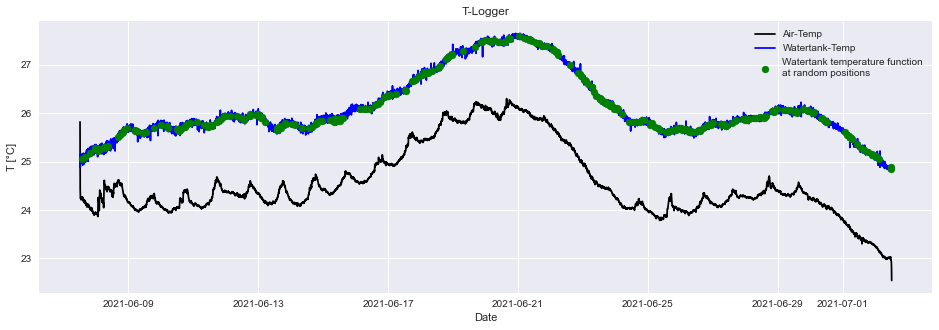

In [9]:
# Plot T-Logger data
number_test_watertank_function = 300 #Input

watertank_T_range_min = df_Tlogger["Channel1-Watertank"].index.min()
watertank_T_range_max = df_Tlogger["Channel1-Watertank"].index.max()

# generate random dates in range of T-Logger dates
random_date_list=[]
for number in range(number_test_watertank_function):
    r_date = random_date(watertank_T_range_min,watertank_T_range_max)
    random_date_list.append(r_date)

# Plot function and data, to see if it is good
y=df_Tlogger["Channel1-Watertank"].values
x_dates=df_Tlogger["Channel1-Watertank"].index
T_avearage=temp_watertank_func(random_date_list) #only use every 10 value, to make it faster
# I could also plot it like this, but this does not show, that my function works
#plt.plot(df_Tlogger["Channel1-rolling_mean"].index,df_Tlogger["Channel1-rolling_mean"].values,label="Watertank rolling mean")
plt.figure(figsize=(16,5))
plt.plot(df_Tlogger["Channel2-Air"].index,df_Tlogger["Channel2-Air"].values,label="Air-Temp",color="black",zorder=8)
plt.plot(x_dates,y,label="Watertank-Temp",color="blue",zorder=9)
plt.scatter(random_date_list,T_avearage,label="Watertank temperature function\nat random positions",color="green",zorder=10)
plt.ylabel("T [°C]")
plt.xlabel("Date")
plt.title("T-Logger")
plt.legend()
plt.show()
#Wassertank am 07.06.2021 aufgefüllt, mit kälteren Wasser

In [10]:
# # Fit function to watertank temperatures - Periodic - not good
# x=mdates.date2num(df_Tlogger["Channel1-Watertank"].index)
# y=df_Tlogger["Channel1-Watertank"].values

# def test_func(x, a, b):
#     return a * np.sin(b * x)

# params, params_covariance = optimize.curve_fit(test_func, x, y,p0=[2, 2])

# plt.figure(figsize=(6, 4))
# plt.scatter(x, y, label='Data')
# plt.plot(x, test_func(x, params[0], params[1]),
#          label='Fitted function')

# plt.legend(loc='best')

# plt.show()

# Wireline T-Logger

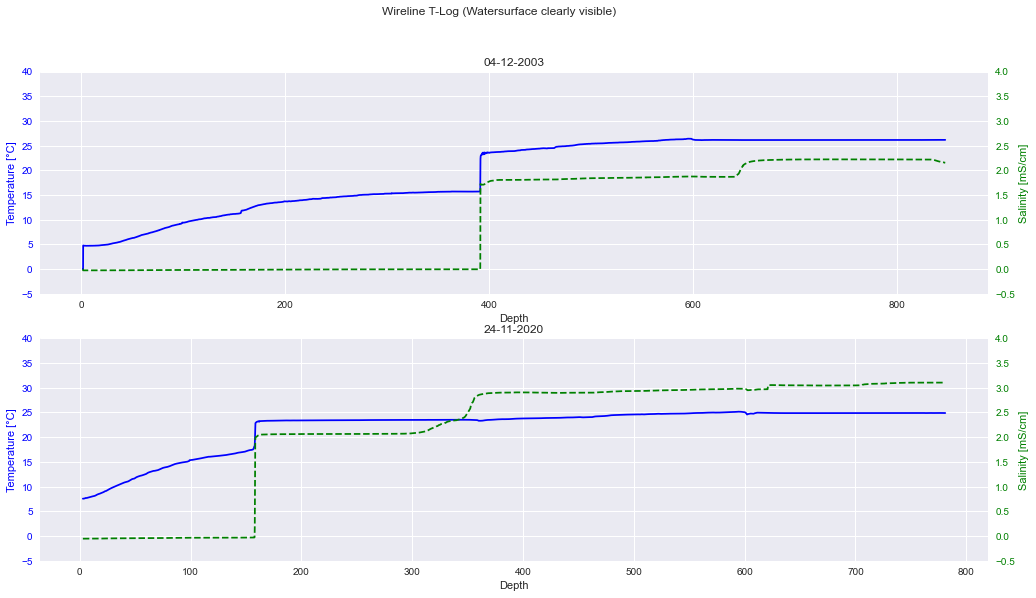

In [11]:
# Load Data
path_to_wireline = r"..\Alsdorf\Daten\PTS_Logs"

filename2003=r"\PTS_2003.csv"
wireline_measurements2003 = pd.read_csv(path_to_wireline + filename2003,skiprows=[0,2,3],index_col=0,na_values=-999.0)
wireline_measurements2003.columns = ["BHT","CBLE_ACC","CURRENT","DIFF-TENSION0","GAMMA","MEASURERANGE","PRESS","SAL","SPEED","TENSION","TIME","VOLTAGE"] #rename columns, because the original names contain empty spaces
wireline_measurements2003 = wireline_measurements2003.dropna()

filename2020=r"\PTS_20201124.csv"
wireline_measurements2020 = pd.read_csv(path_to_wireline + filename2020,index_col=0,skiprows=[0,2,3],na_values=-999.0)
wireline_measurements2020.columns = ["BHT","DEPTH.1","dPress","GAMMA","MEASURERANGE","PRESS","SAL","SPEED","TENSION","TIME"]
wireline_measurements2020 = wireline_measurements2020.drop(columns=["DEPTH.1"]) # the same as DEPTH column
wireline_measurements2020 = wireline_measurements2020.dropna() # drop some nan rows
wireline_measurements2020

# Plot the data
##########Inputs##########
ymin=-5;ymax=40
cBHT="blue";cSAL="green"
lstyle_BHT="-";lstyle_SAL="--"
######################
fig,axs=plt.subplots(2,1,figsize=[17,9])#,constrained_layout=True)
fig.suptitle("Wireline T-Log (Watersurface clearly visible)")
#fig.tight_layout()

axs[0].set_title("04-12-2003") # First axes

axs[0].plot(wireline_measurements2003["BHT"].index,wireline_measurements2003["BHT"].values,color=cBHT,linestyle=lstyle_BHT)#label="Bottom Hole Temperature"
axs[0].set_xlabel("Depth")
axs[0].set_ylabel("Temperature [°C]",color=cBHT)
axs[0].set_ylim(ymin,ymax) # both y-axis have similar scale --> helper lines are alligned
axs[0].tick_params(axis='y', labelcolor=cBHT)

axs0_2 = axs[0].twinx()
axs0_2.plot(wireline_measurements2003["SAL"].index,wireline_measurements2003["SAL"].values,color=cSAL,linestyle=lstyle_SAL)#,label="Salinity")
axs0_2.set_ylabel('Salinity [mS/cm]', color=cSAL)
axs0_2.set_ylim(ymin/10,ymax/10) # both y-axis have similar scale --> helper lines are alligned
axs0_2.tick_params(axis='y', labelcolor=cSAL)
# The grids are not alligned, if not using .set_ylim()
axs0_2.grid(None) #axs is behind the helper lines

axs[1].set_title("24-11-2020") # Second axes

axs[1].plot(wireline_measurements2020["BHT"].index,wireline_measurements2020["BHT"].values,color=cBHT,linestyle=lstyle_BHT)#label="Bottom Hole Temperature"
axs[1].set_xlabel("Depth")
axs[1].set_ylabel("Temperature [°C]",color=cBHT)
axs[1].set_ylim(ymin,ymax) # both y-axis have similar scale --> helper lines are alligned
axs[1].tick_params(axis='y', labelcolor=cBHT)

axs1_2 = axs[1].twinx()
axs1_2.plot(wireline_measurements2020["SAL"].index,wireline_measurements2020["SAL"].values,color=cSAL,linestyle=lstyle_SAL)#,label="Salinity")
axs1_2.set_ylabel('Salinity [mS/cm]', color=cSAL)
axs1_2.set_ylim(ymin/10,ymax/10) # both y-axis have similar scale --> helper lines are alligned
axs1_2.tick_params(axis='y', labelcolor=cSAL)
# The grids are not alligned, if not using .set_ylim()
axs1_2.grid(None) #axs is behind the helper lines

#plt.legend()
plt.show()

# Wie genau funktioniert das gerät, es zeichnet nur den höchsten Wert auf oder?


# Compare EGRT Cable channel 1 - 4 to Wireline T-Logger 2020
Das könnte man evntl. gut nach der Wassertank-Kalibration machen

In [12]:
#

In [13]:
#

# Correct EGRT Cable Measurements with Watertank

In [14]:
%%time
#Wall time: 26.2 s
#25 1689 1723 3389
watertank_len=[25,1689,1723,3389] # position DTS cable, where it is in watertank; vorher [19,1690,1723,3389]
# Wie habe ich aktuell die Wassertank positionen bestimmt: 
# watertank angeguckt und die position finden wo starke änderrungen sind über die Zeit sin --> draußen
# Zwei bis drei Längeneinheiten richtung DTS Gerät gegangen, dort sind dann keine starken Änderrungen über die Zeit 
    # --> Wassertankposition
# Dann die Dataframes von den Channeln die ich mittele so bearbeiten, dass genau die Wassertank positionen gemittelt werden
    # ein parr Längen /Spalten entfernt
# Positionen sind nicht ganz richtig, oder Längen die vom DTS Kabel generiert wurden stimmen nicht

# Correction for waterteank temp difference
def watertank_shift(dataframe,watertank_len=watertank_len,channels=["5","6","7","8"], find_nearest_date=find_nearest_date,watertank_T_range_min=watertank_T_range_min,watertank_T_range_max=watertank_T_range_max):
    """shift the data to the temperature of the first watertank"""
    val_watertank_ch={}
    diff_in_watertank={}
    corrected_val={} # dic for different channel, containing the dataframe of the corrected values

    for chan in channels:
        df_c_v = pd.DataFrame(index=dataframe[chan].columns) # df for the corrected values
        df_c_v.columns.name="Date"

        # find the date range of this channel, which also is covered by the T-Logger
        date_name_min, date_iloc_min = find_nearest_date(watertank_T_range_min,dataframe[chan].index)
        date_name_max, date_iloc_max = find_nearest_date(watertank_T_range_max,dataframe[chan].index)
        all_dates_in_range_channel   = dataframe[chan].index[date_iloc_min:date_iloc_max]
        for date_name in all_dates_in_range_channel:
            # Using chan in the following is somewhat unnecessary, because one date belongs only to one channel
            # But Its not that bad I would say, because it makes things more explicit
            #date_numeric=mdates.date2num(date_name) # create numeric of date for calculations

            # T of DTS cable at first watertank position
            val_watertank_ch[chan]=dataframe[chan].loc[str(date_name)][watertank_len[0]]
            # T of watertank, measured by PT100
            val_watertank=temp_watertank_func([date_name])[0]
            # difference between PT100 and DTS at first watertank position
            # round values may be helpfull for reducing memory, 
            # decimal of 2 would be sufficient for the data accuaracy.
            diff_in_watertank[chan] = val_watertank_ch[chan] - val_watertank

            # correct watertank diff; for all DTS points, based on first watertank position
            chan_val = np.array(dataframe[chan].loc[str(date_name)].values) # uncorrected DTS Temp
            # save corrected values in dataframe; c_v: corrected_value
            df_c_v[date_name] = chan_val - diff_in_watertank[chan]

        # save corected values of the channel in dic
        corrected_val[chan] = df_c_v.transpose() # same format as data_all
    
    return corrected_val

corrected_val = watertank_shift(data_all)

Wall time: 23.8 s


# Process Corrected values
additional processing of the data, e.g. delete outlier

In [15]:
def check_first_last_date(channels=["5","6","7","8"]):
    """check if first and last date of all channels fit to each other
    so that every same index (iloc) corresponds to the closest measurement of the other channel
    """
    for chan in channels:
        len_chan=len(corrected_val_processed[chan].index)
        print(f"Channel: {chan}; Number of dates: {len_chan}")
        f_date=corrected_val_processed[chan].index[0]
        l_date=corrected_val_processed[chan].index[-1]
        print(f"first (oldes) date: {f_date}")
        print(f"last (newest) date: {l_date}")
        print()

In [16]:
#watertank positions
## 25 1689 1723 3389

In [17]:
# remove unrealistiv values of corrected data - relativ großzügig
# channel 5, 6 825 bis 900 a lot of noise in channel 6
corrected_val_processed=deepcopy(corrected_val)
for chan in ["5","6"]:
    for length in range(825,901,1): # from 825 to 900 (both inclusive) delete all values
        corrected_val_processed[chan][length] = np.nan

for chan in ["7","8"]:
    for length in range(1700,1716,1): # from 1700 to 1715 (both inclusive) delete all values
        corrected_val_processed[chan][length] = np.nan

# drop last value, because chan5 is "longer" than chan6; determined by test measurement of DTS device
corrected_val_processed["5"] = corrected_val_processed["5"].drop(1708,axis=1)
# adapt dataframes so that during avearaging (flipping dataframe columns), the watertank positions are avearaged
##################adapt if changing watertank position##########################
# both dataframes have a length of 1708 now (max value length 1707)
#1707-25=1682 # 25 position from the back --> 1689 of one channel is not avearaged with 25 of other channel
corrected_val_processed["5"] = corrected_val_processed["5"].drop([0,1,2,3,4,5,6],axis=1)
corrected_val_processed["6"] = corrected_val_processed["6"].drop([0,1,2,3,4,5,6],axis=1)
# 25 is now index 19 (position 20) and 1689 is index -20; index 0 is avearaged with -1 and so on

corrected_val_processed["7"] = corrected_val_processed["7"].drop([0,1,2,3,4,5],axis=1)
corrected_val_processed["8"] = corrected_val_processed["8"].drop([0,1,2,3,4,5],axis=1)
# 25 is now index 19 (position 20) and 3389 is index -20; index 0 is avearaged with -1 and so on
corrected_val_processed["7"] = corrected_val_processed["7"].drop([1800,1801],axis=1)
corrected_val_processed["8"] = corrected_val_processed["8"].drop([1800,1801],axis=1)
# 1689 is now index 1683 and 1723 is index -1684
#################################################################################


###################### Correct date missmatch, must be done manually at the moment####################################
print("Before removing date points")
check_first_last_date()
print()
corrected_val_processed["5"] = corrected_val_processed["5"].drop(corrected_val_processed["5"].index[-1],axis=0)
corrected_val_processed["6"] = corrected_val_processed["6"].drop(corrected_val_processed["6"].index[0:1],axis=0)
corrected_val_processed["7"] = corrected_val_processed["7"].drop(corrected_val_processed["7"].index[0:1],axis=0)
corrected_val_processed["8"] = corrected_val_processed["8"].drop(corrected_val_processed["8"].index[0:1],axis=0)
# Check if the changes are as expected
print("After removing some date points")
check_first_last_date()
####################################################################################################################



Before removing date points
Channel: 5; Number of dates: 1120
first (oldes) date: 2021-06-07 12:28:22
last (newest) date: 2021-07-02 09:42:31

Channel: 6; Number of dates: 1120
first (oldes) date: 2021-06-07 12:00:21
last (newest) date: 2021-07-02 09:14:30

Channel: 7; Number of dates: 1120
first (oldes) date: 2021-06-07 12:04:21
last (newest) date: 2021-07-02 09:18:30

Channel: 8; Number of dates: 1120
first (oldes) date: 2021-06-07 12:08:22
last (newest) date: 2021-07-02 09:22:30


After removing some date points
Channel: 5; Number of dates: 1119
first (oldes) date: 2021-06-07 12:28:22
last (newest) date: 2021-07-02 09:10:30

Channel: 6; Number of dates: 1119
first (oldes) date: 2021-06-07 12:32:23
last (newest) date: 2021-07-02 09:14:30

Channel: 7; Number of dates: 1119
first (oldes) date: 2021-06-07 12:36:23
last (newest) date: 2021-07-02 09:18:30

Channel: 8; Number of dates: 1119
first (oldes) date: 2021-06-07 12:40:23
last (newest) date: 2021-07-02 09:22:30



In [18]:
def check_processed_data(channels=["5","6","7","8"],my_Warning=False):
    """some checks for my processed data"""
    # check if all channels have the same number of date points (index length)
    n={}
    for chan in channels:
        n[chan]=len(corrected_val_processed[chan].index) # number of date points of this channel
    for chan in n:
        for other_chan in n: # it also counts the channel of the upper loop but thats not important
            n_dates_difference = n[chan] - n[other_chan]
            if n_dates_difference != 0:
                my_Warning = True
                print(f"Channel {chan} and Chanel {other_chan} have a different index length --> different number of dates")

    # check if the first measurement of channel 5 has the oldest measurement and the first of channel 8 the newest
    a=corrected_val_processed # for shortening the next line
    if a["5"].index[0] < a["6"].index[0] and a["6"].index[0] < a["7"].index[0] and a["7"].index[0] < a["8"].index[0]:
        #print("order of first dates is good")
        pass
    else:
        my_Warning = True
        print("!order of first dates is not good!")
    # check last dates
    if a["5"].index[-1] < a["6"].index[-1] and a["6"].index[-1] < a["7"].index[-1] and a["7"].index[-1] < a["8"].index[-1]:
        #print("order of last dates is good")
        pass
    else:
        my_Warning = True
        print("!order of last dates is not good!")

    # check all date differences
    allowed_diff_5_min={}
    allowed_diff_9_min={}
    allowed_diff_13_min={}
    allowed_diff_5_min["6 - 5"]  = corrected_val_processed["6"].index - corrected_val_processed["5"].index
    allowed_diff_5_min["7 - 6"]  = corrected_val_processed["7"].index - corrected_val_processed["6"].index
    allowed_diff_5_min["8 - 7"]  = corrected_val_processed["8"].index - corrected_val_processed["7"].index
    allowed_diff_9_min["8 - 6"]  = corrected_val_processed["8"].index - corrected_val_processed["6"].index
    allowed_diff_9_min["7 - 5"]  = corrected_val_processed["7"].index - corrected_val_processed["5"].index
    allowed_diff_13_min["8 - 5"] = corrected_val_processed["8"].index - corrected_val_processed["5"].index

    def print_timediff_warning():
        my_Warning = True
        print("timediff between to dates is not in expected range")
        print(f"in Channel {channelpair}: {timediff}")

    for channelpair in allowed_diff_5_min:
        for timediff in allowed_diff_5_min[channelpair]:
            if timediff > timedelta(minutes=5) or timediff < timedelta(minutes=4):
                print_timediff_warning()
        
    for channelpair in allowed_diff_9_min:
        for timediff in allowed_diff_9_min[channelpair]:
            if timediff > timedelta(minutes=10) or timediff < timedelta(minutes=8):
                print_timediff_warning()

    for timediff in allowed_diff_13_min["8 - 5"]: # has only one channelpair
        if timediff > timedelta(minutes=14) or timediff < timedelta(minutes=12):
            print_timediff_warning()

    return my_Warning

In [19]:
# Check my processed data
my_Warning = check_processed_data()
# Print Warning if one check was wrong
if my_Warning == True:
    print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
    print("!Do the manual check again!")
    print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
else:
    print("All checks OK")
    print("Check timedifferences between channels: OK")
    print("Check first and last date: OK")
    print("Check number date measurements: OK")

All checks OK
Check timedifferences between channels: OK
Check first and last date: OK
Check number date measurements: OK


# Calculate mean of channels

In [20]:
def avearge_two_channels(chanx,chany):
    """one channel (x) is flipped (length). After that the mean of all values is calculated.
    Only used this for processed data
    """
    # now done out of this function - need to adapt avearagefirst before deleting here
    #one dataframe could have less measurements than the other
    n = len(chanx.index) - len(chany.index)
    #drop n last row of larger dataframe
    if len(chanx.index) - len(chany.index) < 0: #chany more data
        n=len(chanx.index) - len(chany.index) #chany more data: n < 0 
        chany=chany[:n]
    elif len(chanx.index) - len(chany.index) > 0: #chanx more data
        n=len(chanx.index) - len(chany.index) #chanx more data: n > 0 
        chanx = chanx[:-n]    
    #now both chan.index (and so the complete dataframe) have the same length

    # now done out of this function - need to adapt avearagefirst before deleting here
    time_diff_allowed = 5 #[min] ----and some point I should add this as input to the function
    # drop first value (oldest date) of one dataframe if the dates are not in the allowed time diff range
    for i in range(5): #check this 5 times, should be more than enough
        ts1=chanx.index[i] # ts: timestamp
        ts2=chany.index[i]
        if ts1 > ts2:
            if ts1-ts2 > timedelta(minutes=time_diff_allowed): #chany has a much newer date than chanx
                chanx = chanx[:-1] # drop first value of chany (oldest date of both dataframes) and last of chanx
                chany = chany[1:]  # so both dataframes have still the same number of rows
        elif ts1 < ts2:
            if -(ts1-ts2) > timedelta(minutes=time_diff_allowed): #chanx has a much newer date than chany
                chanx = chanx[1:] # drop first value of chanx (oldest date of both dataframes) and last of chany
                chany = chany[:-1]

    # Calculate new index
    # calculate mean of both indexes and check the time difference; checking the time difference is not needed anymore
    #because its already done data processing check. But I think it does not take much computing power, so I left it here
    time_diff_allowed = 5
    new_index=[]
    for i in range(len(chanx)):
        ts1=chanx.index[i] # ts: timestamp
        ts2=chany.index[i]
        # calculate mean time of both channels, it will be used as index for the result.
        if ts1 > ts2:
            tsmean=ts1+(ts1-ts2)/2
            if ts1-ts2 > timedelta(minutes=time_diff_allowed): 
                print(f"Warning 1: Large time difference between both channels: {ts1-ts2}")
        elif ts1 < ts2:
            tsmean=ts2-(ts1-ts2)/2
            if -(ts1-ts2) > timedelta(minutes=time_diff_allowed):
                print(f"Warning 2: Large time difference between both channels: {-(ts1-ts2)}")
        else:
            print("Warning 3: Timestamps equal. Not expected")
        new_index.append(tsmean.round(freq="S"))
    new_index=pd.Series(new_index,name="Date") # to series so it can be used in .set_index

    # change index, so they are equal
    chany = chany.set_index(new_index)
    chanx = chanx.set_index(new_index)
    # flip dataframe one channel (channel 5)
    # Two possibilities
    # 1. Flip data of dataframe
    # chanx = chanx[chanx.columns[::-1]] # flip the whole dataframe: columns and data
    # chanx.columns = chanx.columns[::-1] # datframes are added based on column names, so I need to change them in one dataframe
    # 2. flip only columns, because by adding two dataframes the values with the same column name are added
    chanx.columns = chanx.columns[::-1]
    # calculate mean of Temperature values
    chanxy_mean = (chanx + chany)/2

    return chanxy_mean

# Create mean of channels
chan5and6_mean = avearge_two_channels(corrected_val_processed["5"], corrected_val_processed["6"])
chan7and8_mean = avearge_two_channels(corrected_val_processed["7"], corrected_val_processed["8"])

chan_mean={}
# columns (length) corresponds to second channel, channel 6 and channel 8
chan_mean["5and6"]=chan5and6_mean
chan_mean["7and8"]=chan7and8_mean

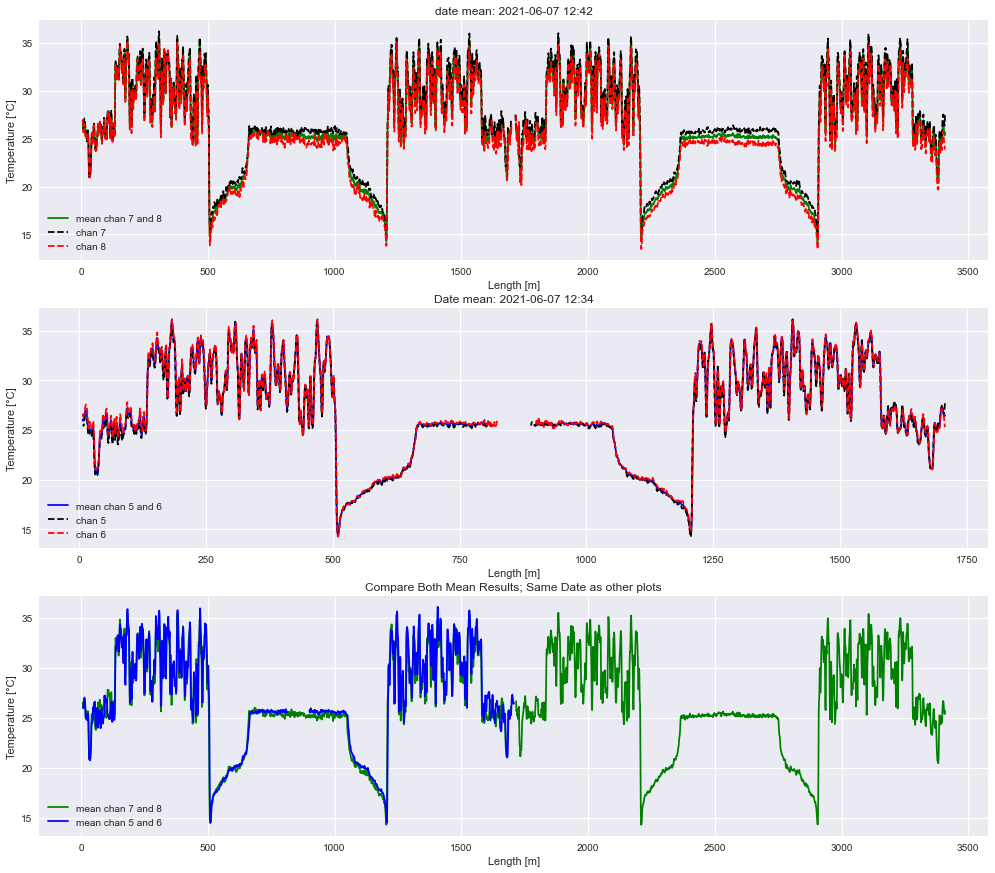

be aware, that for calculating the mean one courve has to be shifted for a few (4) minutes


In [21]:
# Plot mean vlaues compared to channel values
date_iloc=0 #change me
fig,axs=plt.subplots(3,1,figsize=[17,15])#,constrained_layout=True)

axs[0].plot(chan7and8_mean.iloc[date_iloc].index,chan7and8_mean.iloc[date_iloc].values, label="mean chan 7 and 8", color="green")
# get correspnding dates of chan 7 and 8
date_name_ch7, date_iloc_ch7 = find_nearest_date(chan7and8_mean.iloc[date_iloc].name,corrected_val_processed["7"].index)
date_name_ch8, date_iloc_ch8 = find_nearest_date(chan7and8_mean.iloc[date_iloc].name,corrected_val_processed["8"].index)
# flip channel 7, also done for mean calculation
axs[0].plot(corrected_val_processed["7"].loc[date_name_ch7].index[::-1], corrected_val_processed["7"].loc[date_name_ch7].values, label="chan 7",linestyle="--", color="black")
axs[0].plot(corrected_val_processed["8"].loc[date_name_ch8].index, corrected_val_processed["8"].loc[date_name_ch8].values, label="chan 8",linestyle="--", color="red")
axs[0].set_title(f"date mean: {chan7and8_mean.iloc[date_iloc].name.strftime('%Y-%m-%d %H:%M') }") # drop seconds

axs[1].plot(chan5and6_mean.iloc[date_iloc].index,chan5and6_mean.iloc[date_iloc].values, label="mean chan 5 and 6", color="blue")
# get correspnding dates of chan 5 and 6
date_name_ch5, date_iloc_ch5 = find_nearest_date(chan5and6_mean.iloc[date_iloc].name,corrected_val_processed["5"].index)
date_name_ch6, date_iloc_ch6 = find_nearest_date(chan5and6_mean.iloc[date_iloc].name,corrected_val_processed["6"].index)
# flip channel 5, also done for mean calculation
axs[1].plot(corrected_val_processed["5"].loc[date_name_ch5].index[::-1], corrected_val_processed["5"].loc[date_name_ch5].values, label="chan 5",linestyle="--", color="black")
axs[1].plot(corrected_val_processed["6"].loc[date_name_ch6].index, corrected_val_processed["6"].loc[date_name_ch6].values, label="chan 6",linestyle="--", color="red")
axs[1].set_title(f"Date mean: {chan5and6_mean.iloc[date_iloc].name.strftime('%Y-%m-%d %H:%M')}") # drop seconds

axs[2].plot(chan7and8_mean.iloc[0].index,chan7and8_mean.iloc[date_iloc].values, label="mean chan 7 and 8", color="green")
axs[2].plot(chan5and6_mean.iloc[0].index,chan5and6_mean.iloc[date_iloc].values, label="mean chan 5 and 6", color="blue")
axs[2].set_title(f"Compare Both Mean Results; Same Date as other plots")

for ax in axs:
    ax.set_xlabel("Length [m]")
    ax.set_ylabel("Temperature [°C]")
    ax.legend()

plt.show()
print("be aware, that for calculating the mean one courve has to be shifted for a few (4) minutes")

# Avearge first and make the watertank correction after that
# gesammte Berechnung und analysen muss ich mir nochmak angucken!

In [22]:
# selben anpassungen wie bei process machen mit den columns droppen
########################################################################################################
# Funktion von processing steps erstellen, damit das hier besser eingebaut werden kann, oder processing vor watertank shift machen
###########################################################################################################

# Avearge data_all
chan5_mean_calc_aveargefirst = data_all["5"].drop(1708,axis=1) # drop last value, because chan5 is "longer" than chan6

# adapt dataframes so that during avearaging (flipping dataframe columns), the watertank positions are avearaged
##################adapt if changing watertank position##########################
# both dataframes have a length of 1708 now (max value length 1707)
#1707-25=1682 # 25 position from the back --> 1689 of one channel is not avearaged with 25 of other channel
chan5_mean_calc_aveargefirst = chan5_mean_calc_aveargefirst.drop([0,1,2,3,4,5,6],axis=1)
chan6_mean_calc_aveargefirst = data_all["6"].drop([0,1,2,3,4,5,6],axis=1)
# 25 is now index 19 (position 20) and 1689 is index -20; index 0 is avearaged with -1 and so on

chan7_mean_calc_aveargefirst = data_all["7"].drop([0,1,2,3,4,5],axis=1)
chan8_mean_calc_aveargefirst = data_all["8"].drop([0,1,2,3,4,5],axis=1)
# 25 is now index 19 (position 20) and 3389 is index -20; index 0 is avearaged with -1 and so on
chan7_mean_calc_aveargefirst = chan7_mean_calc_aveargefirst.drop([1800,1801],axis=1)
chan8_mean_calc_aveargefirst = chan8_mean_calc_aveargefirst.drop([1800,1801],axis=1)
# 1689 is now index 1683 and 1723 is index -1684
#################################################################################

chan5and6_mean_aveargefirst = avearge_two_channels(chan5_mean_calc_aveargefirst, chan6_mean_calc_aveargefirst)
chan7and8_mean_aveargefirst = avearge_two_channels(chan7_mean_calc_aveargefirst, chan8_mean_calc_aveargefirst)
chan_mean_aveargefirst={}
chan_mean_aveargefirst["5and6"]=chan5and6_mean_aveargefirst
chan_mean_aveargefirst["7and8"]=chan7and8_mean_aveargefirst

# auf Wassertank verschieben bei watertank_len[0] m
corrected_val_avearagefirst = watertank_shift(chan_mean_aveargefirst,channels=["5and6","7and8"])

# Process data --> remove outliers
# doing this before watertank correction gives problems due to nan?
for length in range(825,901,1): # from 825 to 900 (both inclusive) delete all values
    corrected_val_avearagefirst["5and6"][length] = np.nan
for length in range(1700,1716,1): # from 1700 to 1715 (both inclusive) delete all values
    corrected_val_avearagefirst["7and8"][length] = np.nan

# Differenzen berechnen zu anderen Wassertanks
#sihe unten

In [23]:
chan5_mean_calc_aveargefirst.index

DatetimeIndex(['2021-06-01 13:26:07', '2021-06-01 13:58:08',
               '2021-06-01 14:30:10', '2021-06-01 15:02:11',
               '2021-06-01 15:34:12', '2021-06-01 16:06:14',
               '2021-06-01 16:38:15', '2021-06-01 17:10:17',
               '2021-06-01 17:42:18', '2021-06-01 18:14:19',
               ...
               '2021-07-02 05:26:20', '2021-07-02 05:58:21',
               '2021-07-02 06:30:23', '2021-07-02 07:02:24',
               '2021-07-02 07:34:25', '2021-07-02 08:06:27',
               '2021-07-02 08:38:28', '2021-07-02 09:10:30',
               '2021-07-02 09:42:31', '2021-07-02 10:14:32'],
              dtype='datetime64[ns]', name='Date', length=1389, freq=None)

In [24]:
chan6_mean_calc_aveargefirst.index

DatetimeIndex(['2021-06-01 13:30:07', '2021-06-01 14:02:08',
               '2021-06-01 14:34:10', '2021-06-01 15:06:11',
               '2021-06-01 15:38:13', '2021-06-01 16:10:14',
               '2021-06-01 16:42:15', '2021-06-01 17:14:17',
               '2021-06-01 17:46:18', '2021-06-01 18:18:20',
               ...
               '2021-07-02 04:58:18', '2021-07-02 05:30:20',
               '2021-07-02 06:02:21', '2021-07-02 06:34:23',
               '2021-07-02 07:06:24', '2021-07-02 07:38:25',
               '2021-07-02 08:10:27', '2021-07-02 08:42:28',
               '2021-07-02 09:14:30', '2021-07-02 09:46:31'],
              dtype='datetime64[ns]', name='Date', length=1388, freq=None)

# Processing of channel 1-4

In [25]:
# # channel 1-4 are not corrected yet
# for chan in ["1","2","3","4"]:
#     corrected_val[chan] = data_all[chan]

# Plot Data

In [26]:
def interactive_plot_function(data_type,channel,date,display_from,display_to,ymin,ymax,show_mean_chan5and6,show_mean_chan7and8,color_plot,plot_wireline,offset_wireline,offset_old_cable):

    if data_type == "data_all":
        data = data_all
    elif data_type == "corrected_val":
        data = corrected_val
    elif data_type == "corrected_val_processed":
        data = corrected_val_processed
    
    # I need to define this function in here, so it can be used in interactive. Copied it from above (non-interactive plot)
    def color_cable_pos(start_len, end_len, col, ymax, ymin, label_name, label=True):
        """ creates patches which color the plot"""
        width = end_len - start_len
        Rectangle=patches.Rectangle(xy=[start_len,ymin],width=width,height=ymax+ymin,color=col,alpha=0.2)
        axs.add_patch(Rectangle)
        if label and display_from < start_len+width/2 and display_to > start_len+width/2:
            #axs.annotate(label_name,[start_len+width/2, ymax-(ymax-ymin)*0.9],size=15)
            bbox_props=dict(boxstyle="round",fc=col, ec="0.5", alpha=0.0)
            axs.text(start_len+width/2,ymax-(ymax-ymin)*0.1,label_name,ha="center",va="center",size=15,bbox=bbox_props)


    val={}
    fig,axs=plt.subplots(1,1,figsize=[18,5],constrained_layout=True)
    #Plot Data
    for chan in channel:
        length=data[chan].iloc[date].index[display_from:display_to]
        x=np.array(length).astype(int)#[:int(int(length[-1])/2)] #use this if plot half the cable; channel 7,8 - Was wollte ich damit sagen?
        val[chan]=np.array(data[chan].iloc[date].values)[display_from:display_to] #- diff_in_watertank[chan]
        date_name=data[chan].iloc[date].name

        y=val[chan]#[:int(int(length[-1])/2)] #use this if plot half the cable; channel 7,8
        if chan in ["1","2","3","4"]:
            x=x+offset_old_cable
        axs.plot(x , y,label=f"channel {chan}")
    if data_type == "data_all":
        axs.set_title(f"uncorrected data from {data[chan].iloc[date].name}")
    if data_type == "corrected_val":
        axs.set_title(f"corrected data from {data[chan].iloc[date].name}")
    if data_type == "corrected_val_processed":
        axs.set_title(f"corrected processed data from {data[chan].iloc[date].name}")
    if data_type == "nothing: select channel []":
        axs.set_title(f"plotted nothing")

    axs.set_ylim(ymin,ymax)
    axs.set_xlim(display_from,display_to)
    axs.set_xlabel("Length [m]")
    axs.set_ylabel("Temperature [°C]")

    if plot_wireline:
        #offset_wireline: offset, so that curve fits to EGRT cable
        length = wireline_measurements2003["BHT"].index + offset_wireline
        Temp   = wireline_measurements2003["BHT"].values
        axs.plot(length, Temp, label="Wireline T-Log\n04.12.2003")
        length = wireline_measurements2020["BHT"].index + offset_wireline
        Temp   = wireline_measurements2020["BHT"].values
        axs.plot(length, Temp, label="Wireline T-Log\n24.11.2020")

    if show_mean_chan5and6:
        length_mean56=chan5and6_mean.iloc[date].index[display_from:display_to]
        x=np.array(length_mean56).astype(int)
        y=chan5and6_mean.iloc[date].values[display_from:display_to] #- diff_in_watertank[chan]
        date_name_chan56=chan5and6_mean.iloc[date].name
        axs.plot(x, y,label=f"channel mean 5 and 6\nDate: {date_name_chan56}")

    if show_mean_chan7and8:
        length_mean78=chan7and8_mean.iloc[date].index[display_from:display_to]
        x=np.array(length_mean78).astype(int)
        y=chan7and8_mean.iloc[date].values[display_from:display_to] #- diff_in_watertank[chan]
        date_name_chan78=chan7and8_mean.iloc[date].name
        axs.plot(x, y,label=f"channel mean 7 and 8\nDate: {date_name_chan78}")
        

    #splice_pos=1707 # splice position of long cable, not exactly at middle due to pig tail
    #plt.vlines(splice_pos,5,40, color="black",label="splice position?")
    #plt.vlines([splice_pos+10,splice_pos-10,splice_pos+17,splice_pos-17],5,40,label="watertank position?")
    #plt.vlines([splice_pos+14,splice_pos-14],ymin=5,ymax=40,label="watertank position?",linestyles="dashed")
    #plt.vlines([1580,1595],ymin=5,ymax=40,label="watertank position?",linestyles="dashed")


    # # Positions Cable buried - txt field
    # size=11; y=25; ha="center"; va="center"
    # bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.9)
    # x=36
    # if display_from < x and display_to > x:
    #     y=data_all[chan].iloc[date][x] - 8
    #     plt.text(x, y,"Cable buried", ha=ha, va=va, size=size, bbox=bbox_props)
    # x=130
    # if display_from < x and display_to > x:
    #     y=data_all[chan].iloc[date][x] - 8
    #     plt.text(x, y,"Cable buried", ha=ha, va=va, size=size, bbox=bbox_props)

    #axs[n].vlines(start_time_alsd, ymin=0, ymax=330, label="Approx. start of Alsdorf Data", colors="black",linestyles="-")

    if color_plot == True:
        # Beginn water?
        axs.vlines(668,ymin,ymax, color="blue", label="begin water")
        axs.vlines(1050,ymin,ymax, color="blue")
        color_cable_pos(668,1050,"blue",ymax,ymin,label_name="Water")
        axs.vlines(859,ymin,ymax, color="blue", linestyle="--", label="bend point") # Bend point?
        if "7" in channel or "8" in channel:
            axs.vlines(2368,ymin,ymax, color="blue")
            axs.vlines(2750,ymin,ymax, color="blue")
            color_cable_pos(2368,2750,"blue",ymax,ymin, label_name="Water")
            axs.vlines(2559,ymin,ymax, color="blue", linestyle="--") # Bend point?
        # this means the cable goes 355 m deep in the shaft: bend point - Surface: 859 - 504; 2559 - 2203
        # the water table is 668 - 504 = 164 m depth: water table - surface 
        # other numbers 2368 - 2203 = 165 m depth
        # Passt zur Ausbauskizze von 2019, da waren es 169 m
        
        # Cable Buried; two positions are buried: 1, 2
        color_cable_pos(31,41,"brown",ymax,ymin,label_name="Buried",label=False) #1
        color_cable_pos(121,134,"brown",ymax,ymin,label_name="Buried",label=False)#2
        color_cable_pos(1580,1593,"brown",ymax,ymin,label_name="Buried",label=False)#2
        color_cable_pos(1674,1684,"brown",ymax,ymin,label_name="Buried",label=False)#1
        if "7" in channel or "8" in channel:
            color_cable_pos(1732,1742,"brown",ymax,ymin,label_name="Buried",label=False)#1
            color_cable_pos(1820,1833,"brown",ymax,ymin,label_name="Buried",label=False)#1
            color_cable_pos(3280,3293,"brown",ymax,ymin,label_name="Buried",label=False)#2
            color_cable_pos(3374,3384,"brown",ymax,ymin,label_name="Buried",label=False)#1

        #Position cable Fence
        color_cable_pos(1593,1674,"green",ymax,ymin,label_name="Fence")
        color_cable_pos(41,121,"green",ymax,ymin,label_name="Fence")
        if "7" in channel or "8" in channel:
            color_cable_pos(1742,1820,"green",ymax,ymin,label_name="Fence")
            color_cable_pos(3293,3374,"green",ymax,ymin,label_name="Fence")

        #Position cable at surface 
        color_cable_pos(134,508,"yellow",ymax,ymin,label_name="Surface")
        color_cable_pos(1210,1580,"yellow",ymax,ymin,label_name="Surface")
        if "7" in channel or "8" in channel:
            color_cable_pos(1833,2203,"yellow",ymax,ymin,label_name="Surface")
            color_cable_pos(2910,3280,"yellow",ymax,ymin,label_name="Surface")

        #Position cable Watertank -------------unsure-----------should change Temp of watertank to be sure
        color_cable_pos(18,20,"blue",ymax,ymin,label_name="Watertank",label=False)
        axs.vlines(18,ymin,ymax, color="black", label="Watertank")
        axs.vlines(20,ymin,ymax, color="black")
        #data["5"].columns[-20] # --> 1689; -20 because last value corresponds to 0
        color_cable_pos(1689,1691,"blue",ymax,ymin,label_name="Watertank",label=False)
        axs.vlines(1689,ymin,ymax, color="black")
        axs.vlines(1691,ymin,ymax, color="black")
        if "7" in channel or "8" in channel:
            color_cable_pos(1722,1724,"blue",ymax,ymin,label_name="Watertank",label=False)
            axs.vlines(1722,ymin,ymax, color="black")
            axs.vlines(1724,ymin,ymax, color="black")
            color_cable_pos(3388,3390,"blue",ymax,ymin,label_name="Watertank",label=False)
            axs.vlines(3388,ymin,ymax, color="black")
            axs.vlines(3390,ymin,ymax, color="black")

    axs.legend()
    #save_path = "pictures/overview.png"
    #save_path_dpi720 = "pictures/dpi720/overview_dpi720.png"
    #plt.savefig(save_path)
    #plt.savefig(save_path_dpi720, dpi=720)
    plt.show()

In [27]:
# Color Plot for EGRT cable - Interactive
# maybe this libary is better:
# I think this includes some hovering information 
#https://plotly.com/python/creating-and-updating-figures/ # mpsste da mal ein basic tutoial zu machen
#implementing hovering in matplotlib is rather difficult
#https://stackoverflow.com/questions/7908636/is-it-possible-to-make-labels-appear-when-hovering-mouse-over-a-point-in-matplot
#I use this libary:
#https://ipywidgets.readthedocs.io/en/latest/examples/Using%20Interact.html#interactive

interact(interactive_plot_function,
data_type=["corrected_val_processed","corrected_val","data_all","nothing: select channel []"],
channel=[["5","6"],["7","8"],["5","6","7","8"],"5","6","7","8",["1","2","3","4"],["1","2","3","4","5","6","7","8"],[]],
date=widgets.IntSlider(min=0, max=310, step=1, value=10), # not optimal
display_from=widgets.IntSlider(min=0, max=3350, step=10, value=0), 
display_to=widgets.IntSlider(min=10, max=3700, step=10, value=1950),
ymin=widgets.IntSlider(min=0, max=100, step=5, value=5),
ymax=widgets.IntSlider(min=5, max=100, step=5, value=50),
color_plot=True,
plot_wireline=False,
show_mean_chan5and6=False,
show_mean_chan7and8=False,
offset_wireline=widgets.IntSlider(min=0, max=3000, step=2, value=508), #value is same as end cable surface color
offset_old_cable=widgets.IntSlider(min=0, max=3000, step=2, value=306))

#from last measurements; compare -20 and -265 for determine of colors; range 0 bis 310

# Ideen:
# this means the cable goes 355 m deep in the shaft: bend point - Surface: 859 - 504
# other numbers: 2559 - 2203 = 356 m
# the water table is 668 - 504 = 164 m depth: water table - surface 
# other numbers 2368 - 2203 = 165 m depth
# Passt zur Ausbauskizze von 2019, da waren es 169 m
# Ist seit der Wireline Messung das Wasser über 200 m angestiegen? Bedeutet Sprung in Wireline-log nicht beginn Wasser?

# Pegelmessung aus IP noch einfügen

############Werte noch mit Notizen von Kabellänge überprüfen!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# In sich sind die Werte nicht ganz stimmig! (ein paar Meter Abweichung)
#   --> coloring positionen noch leicht anpassen, sodass alle Flächen gleich groß sind

# Vergleiche Plots:
# S. 25 Green Abschlussbericht
# Anl_04_433_15_004.pdf
# Wireline Plot

interactive(children=(Dropdown(description='data_type', options=('corrected_val_processed', 'corrected_val', '…

<function __main__.interactive_plot_function(data_type, channel, date, display_from, display_to, ymin, ymax, show_mean_chan5and6, show_mean_chan7and8, color_plot, plot_wireline, offset_wireline, offset_old_cable)>

# Compare Differences of Corrected Data

In [28]:
def diff_to_watertank(data_calc, find_nearest_date = find_nearest_date, watertank_len = watertank_len, watertank_T_range_min = watertank_T_range_min, watertank_T_range_max = watertank_T_range_max):
    """Calculate differences of corrected values to watertank
    alle variables I need and defined before are as default inputs

    pos: Temp von DTS höher als in Wassertank
    neg: Temp von DTS niedriger als in Wassertank
    """
    
    diff_watertank_aftercorr_alldates={}
    for chan in data_calc.keys():
        # df for watertank diffs of corrected values
        diff_watertank_aftercorr = pd.DataFrame(index=watertank_len)
            
        # find the date range of this channel, which also is covered by the T-Logger
        # Im prinzip unnötig, da corrcted value eh komplett gecoverde sind von T-logger
        date_name_min, date_iloc_min = find_nearest_date(watertank_T_range_min,data_calc[chan].index)
        date_name_max, date_iloc_max = find_nearest_date(watertank_T_range_max,data_calc[chan].index)
        all_dates_in_range_channel   = data_calc[chan].index[date_iloc_min:date_iloc_max]

        for date_name in all_dates_in_range_channel:
            #date_numeric=mdates.date2num(date_name)# create numeric of date for calculations
            val_watertank=temp_watertank_func([date_name])[0]  # T of watertank, measured by PT100
            # Create dataframe to save diffs at all watertank positions after correction

            # diff at all watertankpositions after correction
            # corrected values of DTS at watertank positions
            
            if chan in ["5","6"] or chan in["5and6"]:
                # corrected values of DTS at watertank positions
                c_v_watertank0 = data_calc[chan][watertank_len[0]][date_name] # c_v: corrected value
                c_v_watertank1 = data_calc[chan][watertank_len[1]][date_name]
                diffs = [c_v_watertank0 - val_watertank, c_v_watertank1 - val_watertank, np.nan, np.nan]
                diff_watertank_aftercorr[date_name] = diffs
            elif chan in ["7","8"] or chan in ["7and8"]: 
                # these channels are longer and contain the last two watertank positions
                # corrected values of DTS at watertank positions
                c_v_watertank0 = data_calc[chan][watertank_len[0]][date_name] # c_v: corrected value
                c_v_watertank1 = data_calc[chan][watertank_len[1]][date_name]
                c_v_watertank2 = data_calc[chan][watertank_len[2]][date_name]
                c_v_watertank3 = data_calc[chan][watertank_len[3]][date_name]
                # differences
                diffs = [c_v_watertank0 - val_watertank, c_v_watertank1 - val_watertank, c_v_watertank2 - val_watertank, c_v_watertank3 - val_watertank]
                diff_watertank_aftercorr[date_name] = diffs

        # save diffs to other watertank positions of this channel in dic
        diff_watertank_aftercorr_alldates[chan] = diff_watertank_aftercorr #variable evntl. noch umbennen
    
    return diff_watertank_aftercorr_alldates


diff_watertank_aftercorr_alldates              = diff_to_watertank(data_calc = corrected_val)
diff_watertank_aftercorr_afterprocess_alldates = diff_to_watertank(data_calc = corrected_val_processed)

In [29]:
# Calculate differences to watertank temperature at all waterank positions for all date range of T-Logger
def calc_mean_diff_watertank(diff_watertank_aftercorr_alldates):
    """Calculate Mean values of differences at all watertank positions"""
    # Create Dataframe
    columns = list(diff_watertank_aftercorr_alldates.keys()) # chnnel numbers
    mean_diff = pd.DataFrame(index = watertank_len, columns = columns)
    mean_diff.index.names    = ["Length [m]"]
    mean_diff.columns.names  = ["Channel"]
    n_data = "n_data"
    stdev_diff = pd.DataFrame(index = watertank_len, columns = columns + [n_data])
    stdev_diff.index.names   = ["Length [m]"]
    stdev_diff.columns.names = ["Channel"]
    # Calculate mean for every channel
    for chan in columns:
        for length in mean_diff[chan].index:
            mean_diff[chan][length]  = statistics.mean(diff_watertank_aftercorr_alldates[chan].loc[length])
            stdev_diff[chan][length] = statistics.stdev(diff_watertank_aftercorr_alldates[chan].loc[length])
            stdev_diff["n_data"][length] = len(diff_watertank_aftercorr_alldates[chan].loc[length])
    return mean_diff, stdev_diff

print(f"curves are shifted at length {watertank_len[0]} m to watertank value")
print("at the other length they are compared to the watertank temperature")
print("these are the mean diffeneces of the absolute difference for each date")
# both means are the same, because in processing I did not change anything at the watertank position (26062021)
mean_diff, stdev_diff = calc_mean_diff_watertank(diff_watertank_aftercorr_alldates)
mean_diff_afterprocess, stdev_diff_afterprocess = calc_mean_diff_watertank(diff_watertank_aftercorr_afterprocess_alldates)
print("Mean")
display(mean_diff)
print("Standart Deviation")
display(stdev_diff)

# Achtung mean Abweichung ist im Moment nocht von absoluten Werten berechnet!
#   evntl. noch neue Spalte in Berechnung für absolute Werte?
#channel 8 1690 und 1723 unterschied sehr groß

curves are shifted at length 25 m to watertank value
at the other length they are compared to the watertank temperature
these are the mean diffeneces of the absolute difference for each date
Mean


Channel            5         6         7         8
Length [m]                                        
25               0.0       0.0       0.0       0.0
1689       -0.703056 -0.087248  0.406756  0.035594
1723             NaN       NaN  0.373396  0.867024
3389             NaN       NaN -0.345541 -1.440009

Standart Deviation


Channel            5         6         7         8 n_data
Length [m]                                               
25               0.0       0.0       0.0       0.0   1119
1689        0.175383  0.220997  0.278297  0.320889   1119
1723             NaN       NaN  0.288395  0.375026   1119
3389             NaN       NaN   0.31781  0.268941   1119

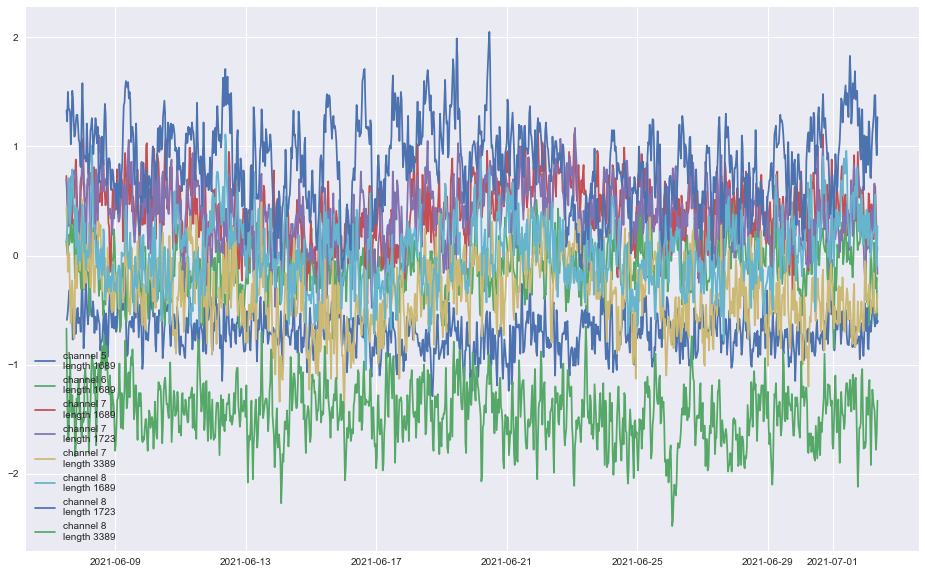

In [30]:
fig,axs=plt.subplots(1,1,figsize=[16,10])
for chan in ["5","6"]:
    axs.plot(diff_watertank_aftercorr_alldates[chan].loc[watertank_len[1]].index,diff_watertank_aftercorr_alldates[chan].loc[watertank_len[1]].values, label=f"channel {chan}\nlength {watertank_len[1]}")
for chan in ["7","8"]:
        axs.plot(diff_watertank_aftercorr_alldates[chan].loc[watertank_len[1]].index,diff_watertank_aftercorr_alldates[chan].loc[watertank_len[1]].values, label=f"channel {chan}\nlength {watertank_len[1]}")
        axs.plot(diff_watertank_aftercorr_alldates[chan].loc[watertank_len[2]].index,diff_watertank_aftercorr_alldates[chan].loc[watertank_len[2]].values, label=f"channel {chan}\nlength {watertank_len[2]}")
        axs.plot(diff_watertank_aftercorr_alldates[chan].loc[watertank_len[3]].index,diff_watertank_aftercorr_alldates[chan].loc[watertank_len[3]].values, label=f"channel {chan}\nlength {watertank_len[3]}")

axs.legend()

In [31]:
# diff watertank of the mean temperature between channels
diff_watertank_aftercorr_afterprocess_aftermean = diff_to_watertank(chan_mean)
mean_diff_afterprocess_aftermean,stdev_diff_afterprocess_aftermean = calc_mean_diff_watertank(diff_watertank_aftercorr_afterprocess_aftermean)
print("mean difference of avearaged channels to watertank, shift first")
display(mean_diff_afterprocess_aftermean)
print("Standart Deviation")
display(stdev_diff_afterprocess_aftermean )
print("Interpretaion:")
print("no clear improvement")

print()
diff_watertank_avearagefirst = diff_to_watertank(corrected_val_avearagefirst)
mean_diff_avearagefirst,stdev_diff_avearagefirst = calc_mean_diff_watertank(diff_watertank_avearagefirst)
print("mean difference of avearaged channels to watertank, averaging first and after that watertank correction")
display(mean_diff_avearagefirst)
print("Standart Deviation")
display(stdev_diff_avearagefirst)
print("Interpretaion:")
print("the difference at length 19 gets smaller; as expected")
print("1723 outlier ? watertank position maybe not correct?")
print("oder gibt es nach avearagen immer noch linearen trned den man korrigieren könnte?")
print("Änderrungen über die Zeit in der Standartabweichung? Habe ich bisher nicht geprüft")

mean difference of avearaged channels to watertank, shift first


Channel        5and6     7and8
Length [m]                    
25         -0.351212 -0.173527
1689       -0.043358  0.203901
1723             NaN  0.636133
3389             NaN -0.720755

Standart Deviation


Channel        5and6     7and8 n_data
Length [m]                           
25          0.088696  0.158365   1118
1689        0.111091  0.218337   1118
1723             NaN  0.250114   1118
3389             NaN  0.134231   1118

Interpretaion:
no clear improvement

mean difference of avearaged channels to watertank, averaging first and after that watertank correction


Channel        5and6     7and8
Length [m]                    
25               0.0       0.0
1689        0.307945  0.377265
1723             NaN   0.80966
3389             NaN -0.547234

Standart Deviation


Channel        5and6     7and8 n_data
Length [m]                           
25               0.0       0.0   1119
1689        0.141152  0.226132   1119
1723             NaN  0.234895   1119
3389             NaN  0.185037   1119

Interpretaion:
the difference at length 19 gets smaller; as expected
1723 outlier ? watertank position maybe not correct?
oder gibt es nach avearagen immer noch linearen trned den man korrigieren könnte?
Änderrungen über die Zeit in der Standartabweichung? Habe ich bisher nicht geprüft


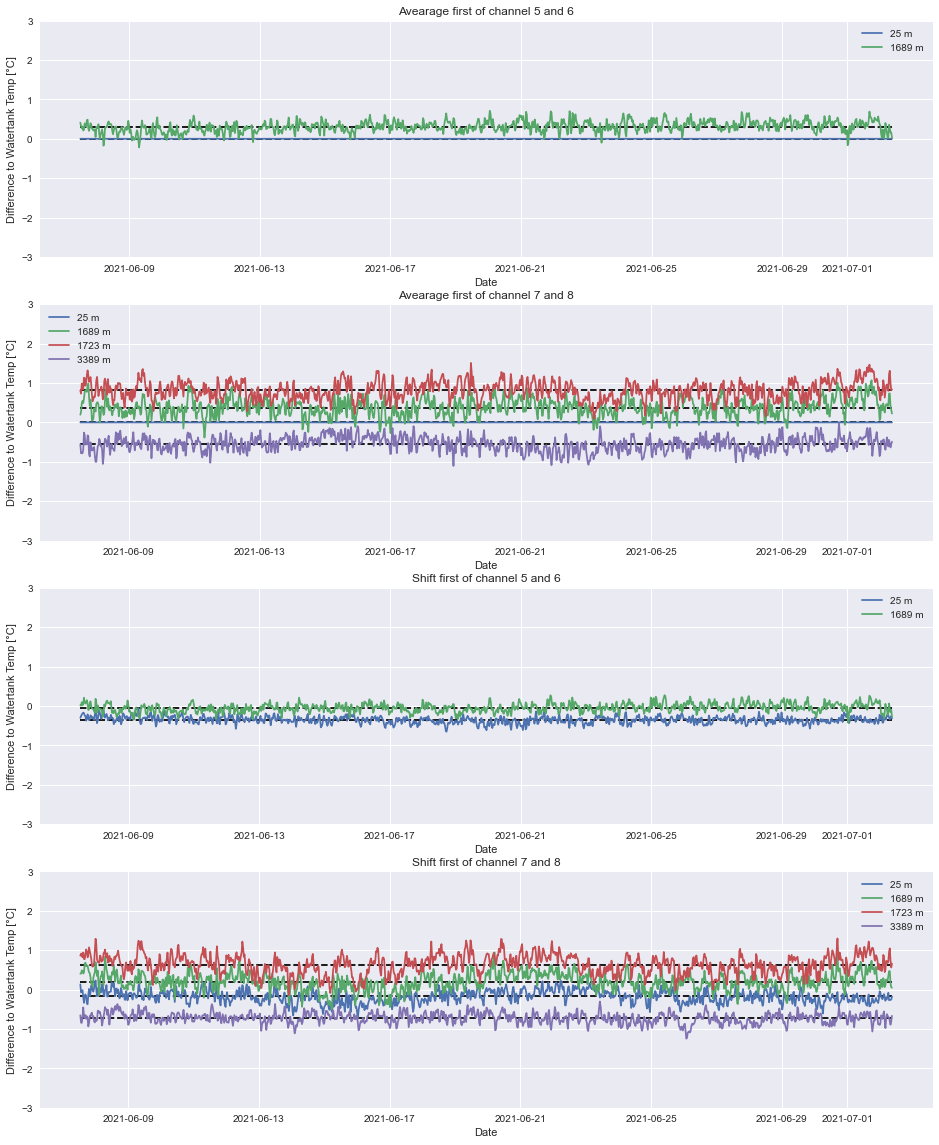

In [32]:
# Plot differences to watertank temperature over time: Avearege first
def plot_helper_9000(diff_watertank_data,mean_diff_data,w_positions,type,name):
    """w_positions: watertank position index you want to plot"""
    for w_pos in w_positions: #watertank position
        w_length = diff_watertank_data[name].index[w_pos] #watertank length
        index=diff_watertank_data[name].iloc[w_pos].index
        values=diff_watertank_data[name].iloc[w_pos].values
        ax.plot(index,values,label=f"{w_length} m")
        ax.hlines(mean_diff_data[name].loc[w_length],index.min(),index.max(),linestyle="--",color="black")
    ax.legend()
    n=name.partition("and")
    ax.set_title(f"{type} of channel {n[0]} {n[1]} {n[2]}")
    ax.set_ylabel("Difference to Watertank Temp [°C]")
    ax.set_xlabel("Date")
    ax.set_ylim(-3,3)

fig,axs=plt.subplots(4,1,figsize=[16,20])
type_name="Avearage first"
counter_ax=0
for ax in axs[0:2]:
    if counter_ax==0:
        plot_helper_9000(diff_watertank_avearagefirst,mean_diff_avearagefirst,[0,1],type=type_name, name="5and6")
        
    if counter_ax==1:
        plot_helper_9000(diff_watertank_avearagefirst,mean_diff_avearagefirst,[0,1,2,3],type=type_name, name="7and8")
    counter_ax+=1

# Plot differences to watertank temperature over time: Shift first
type_name="Shift first"
counter_ax=0
for ax in axs[2:4]:
    if counter_ax==0:
        plot_helper_9000(diff_watertank_aftercorr_afterprocess_aftermean,mean_diff_afterprocess_aftermean,[0,1],type=type_name,name="5and6")
        
    if counter_ax==1:
        plot_helper_9000(diff_watertank_aftercorr_afterprocess_aftermean,mean_diff_afterprocess_aftermean,[0,1,2,3],type=type_name,name="7and8")
    counter_ax+=1

In [33]:
# Noch komplett überarbeiten!!!!!!!!!!!!!!!!!!!!!!!!!!

# calc differnce between two channels
def calc_diff_between_channels(data1,data2,find_nearest_date=find_nearest_date):
    """
    result: dic to store result dataframes in
    """
    all_dates=[]
    result={}
    df_diff=pd.DataFrame()
    df_diff_re=pd.DataFrame()
    df_diff_abs=pd.DataFrame()
    df_diff_abs_re=pd.DataFrame()
    # loop over all dates
    for i in range(1,len(data1.index)-1): #leave put first and last date
        date_name_chy, date_iloc_chy = find_nearest_date(data1.index[i],data2.index)
        date_name_chx = data1.index[i]

        # check difference between the two dates
        allowed_difference = timedelta(minutes=13)
        time_diff = pd.to_datetime(date_name_chy) - date_name_chx
        if time_diff > timedelta(minutes=0):
            if time_diff > allowed_difference:
                print("Warning 1: large time difference")
                print(time_diff)
        elif time_diff < timedelta(minutes=0):
            if time_diff * -1 >  allowed_difference:
                print("Warning 2: large time difference")
                print(time_diff * -1)
        else: #val=0
            print("Something is wrong? No time diff between different channels!")

        # Calculate difference
        T_data1 = data1.loc[date_name_chx] #array with length as index, with all Temp. of the date
        T_data2 = data2.loc[date_name_chy]
        diff = T_data1 - T_data2[::-1] #einen flippen, damit jede Kabelposition gleich ist
        diff_abs = abs(diff)
        diff_re = diff/((T_data1+T_data2)/2) #!!!!!!!!!!!!!!!ist das gut das so zu machen????????????????????????
        diff_re_abs = abs(diff/T_data1)

        # save date in dataframe, date (columns name) is not the mean of both dates used
        df_diff_re[date_name_chx] = diff_re
        df_diff_abs[date_name_chx] = diff_abs
        df_diff_abs_re[date_name_chx] = diff_re_abs
        df_diff[date_name_chx] = diff
    
    result["diff"]= df_diff
    result["diff_abs"]= df_diff_abs
    result["diff_re"]= df_diff_re 
    result["diff_abs_re"]= df_diff_abs_re 
    return result

# Difference for processed data
diff_processed_data=defaultdict(dict)
pairs=[["5","6"],["5","7"],["5","8"],["6","7"],["6","8"],["7","8"]]
all_dates=[] #for determing date range later
for pair in pairs:
    f_ch=pair[0] #first channel
    s_ch=pair[1] #second_channel

    data1 = corrected_val_processed[f_ch]
    data2 = corrected_val_processed[s_ch]

    diff_processed_data[f"{f_ch} - {s_ch}"] = calc_diff_between_channels(data1,data2)
    dates=diff_processed_data[f"{f_ch} - {s_ch}"]["diff"].columns
    all_dates.append(dates)

all_dates = np.array(all_dates).flatten()

# Calculate mean difference (over time)
def mean_diff_channels(dic_diff):
    """calc mean difference for each pair"""
    diff_type="diff" #erstmal nur das benutzen (normale differenz)
    long_exists=False
    mean_diff = pd.DataFrame()
    mean_diff_long = pd.DataFrame() # channel 7-8 are longer, different dataframe needed or a lot of nan values in one dataframe
    for pair in dic_diff.keys():
        if pair == "7 - 8": # longer dataframe
            mean_diff_long[pair] = dic_diff[pair][diff_type].mean(axis=1)
            long_exists=True
        else:
            mean_diff[pair] = dic_diff[pair][diff_type].mean(axis=1)

    if long_exists==True:
        return mean_diff, mean_diff_long
    else:
        return mean_diff

mean_diff, mean_diff_long = mean_diff_channels(diff_processed_data)

In [34]:
# Difference between both avearage data
diff_both_avearagefirst=defaultdict(dict)
diff_both_shiftfirst=defaultdict(dict)
pairs=["5and6","7and8"]
all_dates_avearagefirst=[] #for determing date range later
all_dates_shiftfirst=[]

f_pair=pairs[0] #first avearage pair
s_pair=pairs[1] #second avearage pair

data1 = corrected_val_avearagefirst[f_pair]
data2 = corrected_val_avearagefirst[s_pair]
diff_both_avearagefirst[f"{f_pair} - {s_pair}"] = calc_diff_between_channels(data1,data2)

data1 = chan_mean[f_pair] #chan_mean variable umbennen
data2 = chan_mean[s_pair]
diff_both_shiftfirst[f"{f_pair} - {s_pair}"] = calc_diff_between_channels(data1,data2)

all_dates_avearagefirst.append(diff_both_avearagefirst[f"{f_pair} - {s_pair}"]["diff"].columns)
all_dates_shiftfirst.append(diff_both_shiftfirst[f"{f_pair} - {s_pair}"]["diff"].columns)

all_dates_avearagefirst = np.array(all_dates_avearagefirst).flatten()
all_dates_shiftfirst = np.array(all_dates_shiftfirst).flatten()

# Calculate mean
mean_diff_avearagefirst = mean_diff_channels(diff_both_avearagefirst)
mean_diff_shiftfirst = mean_diff_channels(diff_both_shiftfirst)




# # Difference channel avearage data compare different calculation methods
# dic_diff_5and6 = {}
# dic_diff_7and8 = {}
# pairs=[["5and6","7and8"]]
# all_dates_5and6=[] #for determing date range later
# all_dates_7and8=[]
# for pair in pairs:
    
#     f_ch=pair[0] #first channel
#     s_ch=pair[1] #second_channel

#     data1 = corrected_val_avearagefirst[f_ch]
#     data2 = chan_mean[f_ch]

#     data3 = corrected_val_avearagefirst[s_ch]
#     data4 = chan_mean[s_ch]

#     df_diff_5and6 = calc_diff_between_channels(data1,data2)
#     df_diff_7and8 = calc_diff_between_channels(data3,data4)

#     all_dates_5and6.append(df_diff_5and6.columns)
#     all_dates_7and8.append(df_diff_7and8.columns)

#     dic_diff_5and6[f"{f_ch}"] = df_diff_5and6
#     dic_diff_7and8[f"{s_ch}"] = df_diff_7and8

# all_dates_5and6 = np.array(all_dates_5and6).flatten()
# all_dates_7and8 = np.array(all_dates_7and8).flatten()


# # Calculate mean
# mean_diff_5and6 = mean_diff_channels(dic_diff_5and6)
# mean_diff_7and8 = mean_diff_channels(dic_diff_7and8)

# #no time diff between different channels is expected 

# Plot differences

In [35]:
def plot_one_ax_mean_diff(mean_diff,mean_diff_long,pairs):
        """plots the mean diff between two channels"""
        mean_diff_plot=mean_diff
        
        for pair in pairs:
                if pair == "7 - 8":
                        ax.plot(mean_diff_long[pair].index,mean_diff_long[pair].values,label=pair)
                        mean = np.nanmean(mean_diff_long[pair].values)
                        ax.hlines(mean,0,3400,linestyle="--", color="black",label = "mean over length")
                else:
                        ax.plot(mean_diff_plot[pair].index,mean_diff_plot[pair].values,label=pair)
                        mean=np.nanmean(mean_diff_plot[pair].values)
                        ax.hlines(mean,0,1700,linestyle="--",color="black")

        ax.set_xlabel("Length [m]")
        ax.set_ylabel(f"Difference [°C]")
        #bei größerer Zeitspanne ggf .date benutzen um sekunden wegzulassen
        mi_date=pd.Timestamp(all_dates.min()).round(freq="H")
        ma_date=pd.Timestamp(all_dates.max()).round(freq="H")
        ax.set_title(f"Mean Difference between processed corrected values\nfrom {mi_date} to {ma_date}")
        ax.legend()

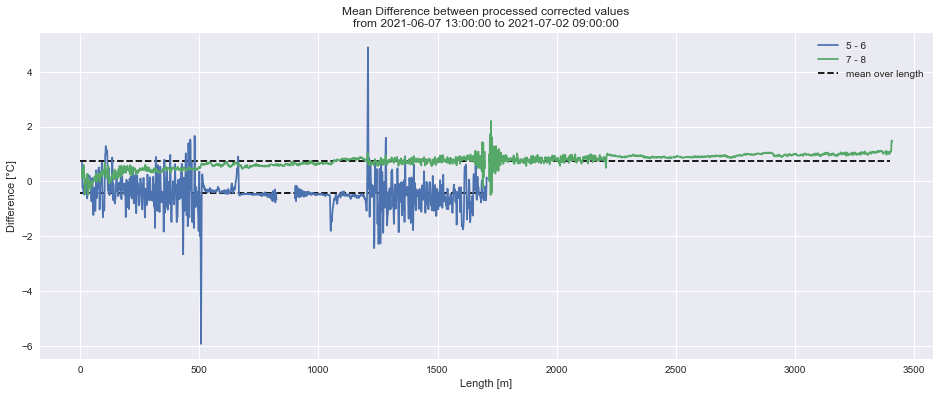

In [36]:
# Plot mean differences of corrected processed Temperature
# I could also plot other diff like relative or absolute
fig,axs=plt.subplots(1,1,figsize=[16,6])
pairs=["5 - 6","7 - 8"]#,"5-7","5-8","6-7","6-8"] #pairs for plotting, have to be in mean_diff.keys()
ax=axs
plot_one_ax_mean_diff(mean_diff,mean_diff_long,pairs)

# High peaks mean, that maybe each cable position is not substracted from ist partner. Length description could be wrong

mean 0.17770919018853565
min 0.17486791898357534
max 0.18064736751280153


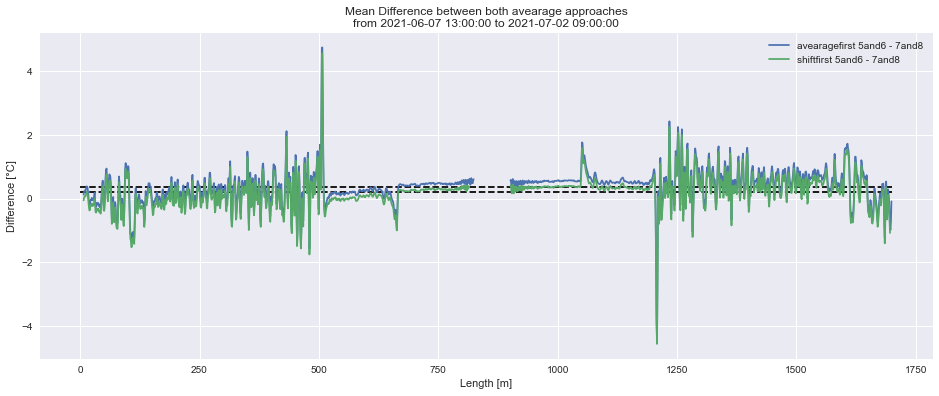

In [37]:
def plot_one_ax_mean_diff_2(mean_diff, name):
        """plots the diffs list, each in one axis"""
        pairs=["5and6 - 7and8"]

        ax.plot(mean_diff[pairs].index,mean_diff[pairs].values,label=f"{name} {pairs[0]}")
        mean=np.nanmean(mean_diff[pairs].values)
        ax.hlines(mean,0,1700,linestyle="--",color="black")

        ax.set_xlabel("Length [m]")
        ax.set_ylabel(f"Difference [°C]")
        #bei größerer Zeitspanne ggf .date benutzen um sekunden wegzulassen
        if name == "avearagefirst":
                all_dates=all_dates_avearagefirst
        elif name == "shiftfirst":
                all_dates=all_dates_shiftfirst
        mi_date=pd.Timestamp(all_dates.min()).round(freq="H")
        ma_date=pd.Timestamp(all_dates.max()).round(freq="H")
        ax.set_title(f"Mean Difference between both avearage approaches\nfrom {mi_date} to {ma_date}")
        ax.legend()

# Plot mean differences of corrected processed avearged Temperature
fig,axs=plt.subplots(1,1,figsize=[16,6])#,constrained_layout=True)

ax=axs

plot_one_ax_mean_diff_2(mean_diff_avearagefirst,"avearagefirst")

plot_one_ax_mean_diff_2(mean_diff_shiftfirst, "shiftfirst")


############################Lagen vorher exact übereinander##################???????????????!!!!!!!!!!!!!!!!!!
# differenz ist konstant: difffff=mean_diff_chanmean - mean_diff_aveargefirst

#Idee: 
# a,b: wahre Temp; a+s1,a+s2: Anzeige Temp DTS Gerät
#
#avearage first: Shift ist nicht konstant über Kabellänge
#a+s1   b+s2
#c=(a+s1+b+s2)/2=(a+b)/2+(s1+s2)/2
#d=(a+b)/2+(s1+s2)/2+swatertank
#
#shift before avearage - norbert sinvoller
#a+s1+swater1   b+s2+swater2
#d=(a+s1+swater1+b+s2+swater2)2
#=(a+b)/2+(s1+s2)/2+(swater1+swater2)/2
#
#Differenz zwischen beiden Ansätzen is dann swatertank - (swater1+swater2)/2

# legend falsch?
# immer 19 korrigieren, ist richtig





# Egal welchen Berechnungsanstaz ich nehme DIfferenzen sind sehr ähnlich zwischen beiden avearage Paaren. Konst offset + eine sehr kleine Schwankung
mean=(mean_diff_avearagefirst["5and6 - 7and8"] - mean_diff_shiftfirst["5and6 - 7and8"]).mean()
mini=(mean_diff_avearagefirst["5and6 - 7and8"] - mean_diff_shiftfirst["5and6 - 7and8"]).min()
maxi=(mean_diff_avearagefirst["5and6 - 7and8"] - mean_diff_shiftfirst["5and6 - 7and8"]).max()
print(f"mean {mean}")
print(f"min {mini}")
print(f"max {maxi}")

In [38]:
# # Plot mean differences of corrected processed Temperature
# fig,axs=plt.subplots(1,1,figsize=[17,9],constrained_layout=True)
# for pair in mean_diff_aveargefirst.keys():
#     axs.plot(mean_diff_aveargefirst[pair].index,mean_diff_aveargefirst[pair].values,label=f"avearegfirst\n{pair}",linewidth=7)
# for pair in mean_diff_chanmean.keys():
#     axs.plot(mean_diff_chanmean[pair].index,mean_diff_chanmean[pair].values,label=f"chanmean\n{pair}")
# axs.set_xlabel("Length [m]")
# axs.set_ylabel("Difference [°C]")
# #bei größerer Zeitspanne ggf .date benutzen
# mi_date=pd.Timestamp(all_dates_aveargefirst.min()).round(freq="H")
# ma_date=pd.Timestamp(all_dates_aveargefirst.max()).round(freq="H")
# axs.set_title(f"Mean Difference between processed corrected avearaged values\nfrom {mi_date} to {ma_date}")
# axs.legend()

In [39]:
# # Plot mean differences of corrected processed Temperature
# fig,axs=plt.subplots(1,1,figsize=[17,9],constrained_layout=True)
# for pair in mean_diff_5and6.keys():
#     axs.plot(mean_diff_5and6[pair].index,mean_diff_5and6[pair].values,label=f"5and6\n{pair}",linewidth=7)
# for pair in mean_diff_7and8.keys():
#     axs.plot(mean_diff_7and8[pair].index,mean_diff_7and8[pair].values,label=f"7and8\n{pair}")
# axs.set_xlabel("Length [m]")
# axs.set_ylabel("Difference [°C]")
# #bei größerer Zeitspanne ggf .date benutzen
# mi_date=pd.Timestamp(all_dates_5and6.min()).round(freq="H")
# ma_date=pd.Timestamp(all_dates_5and6.max()).round(freq="H")
# axs.set_title(f"Mean Difference between the different calculation approaches\nfrom {mi_date} to {ma_date}")
# axs.legend()

# ergibt das Sinn oder habe ich einen Fehler gemacht?
# Es bedeutet:
# ob ich avearge first mache oder nicht hat keinen Einfluss auf unterschied zwischen den beiden Temperaturen der jeweiligen Berechnung
# simple überlegunf sagt eigentlich, dass bei beiden ansätzen das gleiche raus kommen muss
#??????????????????????????
###############überprüfen

In [40]:
corrected_val_processed.keys()

dict_keys(['5', '6', '7', '8'])

In [41]:
# Check how similar the curves are at the watertank positions
# They should be very similar (equal in the range of error) at any other position too
####################I should implement calculation for this too!###############################
##################direkt funktion dafür erstellen#####################################


diff_betweenChan_aftercorr_all_dates={}
# pairs: pair to compare the Temperature values
pairs=[["5","6"],["5","7"],["5","8"],["6","7"],["6","8"],["7","8"]]
for pair in pairs:
    f_ch=pair[0] #first channel
    s_ch=pair[1] #second_channel
    # for each channel the possible dates
    ############### implement check how far apart the dates are######################
    date_name_min_f_ch, date_iloc_min_f_ch = find_nearest_date(watertank_T_range_min,corrected_val_processed[f_ch].index)
    date_name_max_f_ch, date_iloc_max_f_ch = find_nearest_date(watertank_T_range_max,corrected_val_processed[f_ch].index)
    date_name_min_s_ch, date_iloc_min_s_ch = find_nearest_date(watertank_T_range_min,corrected_val_processed[s_ch].index)
    date_name_max_s_ch, date_iloc_max_s_ch = find_nearest_date(watertank_T_range_max,corrected_val_processed[s_ch].index)
    all_dates_in_range_channel_f_ch        = corrected_val_processed[f_ch].index[date_iloc_min_f_ch:date_iloc_max_f_ch]
    all_dates_in_range_channel_s_ch        = corrected_val_processed[s_ch].index[date_iloc_min_s_ch:date_iloc_max_s_ch]



##############################################################################
# date selection sit noch nicht optimal, da es sein kann, dass zwischendurch das Datum von einzelnen channels nicht
# im standart Muster ist, z.B. bei Measurement stops
# ich muss noch mehr checks einbauen die prüfen, dass bei Messungen wirklich nah zusammen sind
# mit den aktuellen Werten müsste es passen, von hand geprüft:
    #if f_ch == "7" and s_ch =="8":
    #    print(all_dates_in_range_channel_f_ch)
    #    print(all_dates_in_range_channel_s_ch)
    # second channel date is after first channel
    #if f_ch == "5" and s_ch =="6":
    #    all_dates_in_range_channel_s_ch=all_dates_in_range_channel_s_ch.drop(all_dates_in_range_channel_s_ch[0])
    
    # while all_dates_in_range_channel_f_ch[0] > all_dates_in_range_channel_s_ch[0]: 
    #     all_dates_in_range_channel_f_ch=all_dates_in_range_channel_f_ch.drop(all_dates_in_range_channel_f_ch[0])
    # #both have the same number of dates
    # while len(all_dates_in_range_channel_s_ch[0]) > len(all_dates_in_range_channel_f_ch[0]): 
    #     all_dates_in_range_channel_s_ch=all_dates_in_range_channel_s_ch.drop(all_dates_in_range_channel_s_ch[-1])
###########################################################################

    # Create dataframe for saving results
    diff_betweenChan_aftercorr = pd.DataFrame(columns=all_dates_in_range_channel_f_ch, index=watertank_len)
    diff_betweenChan_aftercorr.columns.names = ["Date f_ch"]
    diff_betweenChan_aftercorr.index.names   = ["Length [m]"]

    # go through all date pairs
    for date_name_f_ch, date_name_s_ch in zip(all_dates_in_range_channel_f_ch, all_dates_in_range_channel_s_ch):

        # # check difference between the two dates
        # allowed_difference = timedelta(minutes=13)
        # time_diff = pd.to_datetime(date_name_f_ch) - date_name_s_ch
        # if time_diff > timedelta(minutes=0):
        #     if time_diff > allowed_difference:
        #         print("Warning 1: large time difference")
        #         print(time_diff)
        # elif time_diff < timedelta(minutes=0):
        #     if time_diff * -1 >  allowed_difference:
        #         print("Warning 2: large time difference")
        #         print(time_diff * -1)
        # else: #val=0
        #     print("Something is wrong? No time diff between different channels!")






        # fill the dataframe for date pair
        for cable_length in diff_betweenChan_aftercorr.index[:2]: #excluding length which are only in chan 7 and 8
            # corrected Temp of a specific Date, Channel and watertank position
            val1 = corrected_val_processed[f_ch][cable_length][date_name_f_ch]
            val2 = corrected_val_processed[s_ch][cable_length][date_name_s_ch]
            diff_betweenChan_aftercorr[date_name_f_ch][cable_length] = val1 - val2

        if f_ch in ["7","8"] and s_ch in ["7","8"]: # calc diffs for length which are only in chan 7 and 8
            for cable_length in diff_betweenChan_aftercorr.index[2:]:
                # copied from above loop, just different cable_length
                val1 = corrected_val_processed[f_ch][cable_length][date_name_f_ch]
                val2 = corrected_val_processed[s_ch][cable_length][date_name_s_ch]
                diff_betweenChan_aftercorr[date_name_f_ch][cable_length] = val1 -val2

    # save dataframe for each date pair
    diff_betweenChan_aftercorr_all_dates[f"{f_ch} - {s_ch}"] = diff_betweenChan_aftercorr

# Calculate means for each pair over the date period
# Create Dataframe
diff_betweenChan_aftercorr_all_dates_means = pd.DataFrame(index=watertank_len,columns=diff_betweenChan_aftercorr_all_dates.keys())
diff_betweenChan_aftercorr_all_dates_means.index.names=["Length [m]"]
diff_betweenChan_aftercorr_all_dates_means.columns.names=["Channels"]
# Calculation
for pair in diff_betweenChan_aftercorr_all_dates.keys():
    for length in diff_betweenChan_aftercorr_all_dates_means.index:
        # mean value of all pair dates for length
        m_val = np.mean(abs(diff_betweenChan_aftercorr_all_dates[pair].loc[length]))
        diff_betweenChan_aftercorr_all_dates_means[pair][length] = m_val # save mean value

print("these are the means of the abs values of the differences between the shifted channel Temperature. Over the logging period of the T-Logger at the Watertank position")
diff_betweenChan_aftercorr_all_dates_means



# Some Interpretation
# sollte 19 nicht 0 sein? 
#   --> Difference of watertank temperature (of my watertank temperature interpolating function) at the two 
#       different dates of both channels; So this somewhat shows the accuaracy of the PT100 Logger,
#       when assuming the temperature should be constant.
# further away higher difference, can be better seen when taking a look at all length not only watertank

these are the means of the abs values of the differences between the shifted channel Temperature. Over the logging period of the T-Logger at the Watertank position


Channels       5 - 6     5 - 7     5 - 8     6 - 7     6 - 8     7 - 8
Length [m]                                                            
25           0.00855  0.012119  0.014799  0.008874  0.012326   0.00864
1689        0.620101  1.109509  0.741948  0.516837  0.301871  0.446438
1723             NaN       NaN       NaN       NaN       NaN  0.546689
3389             NaN       NaN       NaN       NaN       NaN  1.094355

In [55]:
diff_test = calc_diff_between_channels(corrected_val_processed["5"],corrected_val_processed["6"],find_nearest_date=find_nearest_date)
diff_test["diff_abs"].loc[25].mean() #das gleiche Ergebnis wie das untere


0.00011614001790510083

In [56]:
diff_processed_data["5 - 6"]["diff"].loc[25].mean()

-6.260232766340092e-05

In [45]:
mean_diff.loc[25]

5 - 6   -0.000063
5 - 7    0.000116
5 - 8   -0.000019
6 - 7    0.000179
6 - 8    0.000043
Name: 25, dtype: float64

# Checks

In [46]:
# Checks -geht jetzt denke ich nciht mehr wegen moving avearge
# check if everything works as expected
# both same result, compare with diff_betweenChan_aftercorr_all_dates, to see that the 19 row in this dataframe 
# is the difference between the measured watertank temperature of the PT100
# (interpolated with a function between the data points)
# first calc
val2=temp_watertank_func(['2021-06-07 18:52:39'])
val1=temp_watertank_func(['2021-06-07 18:56:39'])
calc1=val1[0]-val2[0]

# second calc
date_check_ch5='2021-06-07 18:52:39'
timestamp_ch5=pd.Timestamp(date_check_ch5)
date_check_ch6='2021-06-07 18:56:39'
timestamp_ch6=pd.Timestamp(date_check_ch6)
calc2=corrected_val["5"][watertank_len[0]][timestamp_ch5] - corrected_val["6"][watertank_len[0]][timestamp_ch6]

if abs(calc1) != abs(calc2):
    print("Is there something wrong?");print(calc1);print(calc2)
    print("maybe you changed round in watertank_shift() function")

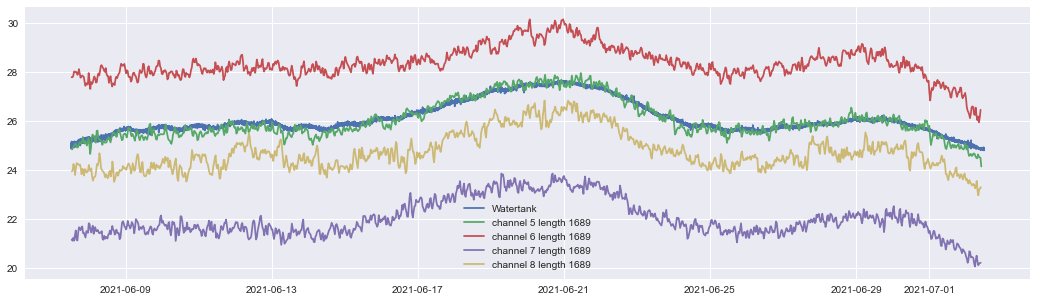

In [47]:
# Compare watertank to uncorrected channels
watertank_EGRT = 1689 # ich muss mir angucken welche Länge bei Mittelung mit dieser gemittelt wird um zu sehen, ob diese Länge
# evntl. schon sußerhalb vom Wassertank ist


plt.figure(figsize=(18,5))
plt.plot(df_Tlogger.index, df_Tlogger["Channel1-Watertank"], label="Watertank")
#plt.plot(df_Tlogger.index, df_Tlogger["Channel2-Air"], label="Air")
for c in ["5","6","7","8"]: #["7","8"]: #: 
    inde=data_2021[c][str(df_Tlogger.index.min()) : str(df_Tlogger.index.max())][watertank_EGRT].index
    val=data_2021[c][str(df_Tlogger.index.min()) : str(df_Tlogger.index.max())][watertank_EGRT].values
    plt.plot(inde,val, label=f"channel {c} length {watertank_EGRT}")

    # inde=data_2021[c][str(df_Tlogger.index.min()) : str(df_Tlogger.index.max())][1707-watertank_EGRT].index
    # val=data_2021[c][str(df_Tlogger.index.min()) : str(df_Tlogger.index.max())][1707-watertank_EGRT].values
    # plt.plot(inde,val, label=f"channel {c} length {1707-watertank_EGRT}")

plt.legend()

In [48]:
# # Compare watertank to uncorrected channels - other watertank position 
# def get_cmap(n, name='hsv'):
#     '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
#     RGB color; the keyword argument name must be a standard mpl colormap name.'''
#     return plt.cm.get_cmap(name, n)
# col=get_cmap(7)

# watertank_EGRT = 19 #unter 20 sind die Temp relativ konstant

# #col=["black","green","blue","yellow"]

# plt.figure(figsize=(18,5))
# #position_watertank=15
# plt.plot(df_Tlogger.index, df_Tlogger["Channel1-Watertank"], label="Watertank")
# #plt.plot(df_Tlogger.index, df_Tlogger["Channel2-Air"], label="Air")
# for c in ["5","6","7","8"]:
#     for watertank_EGRT in [watertank_EGRT]:
#         val=int(data_2021[c].columns[-1]) - watertank_EGRT
#         watertank_EGRT_back=val
#         inde=data_2021[c][str(df_Tlogger.index.min()) : str(df_Tlogger.index.max())][watertank_EGRT_back].index
#         val=data_2021[c][str(df_Tlogger.index.min()) : str(df_Tlogger.index.max())][watertank_EGRT_back].values

#         #plt.plot(inde,val, label=f"channel {c}", color=col[int(c)-5]) # color channels
#         plt.plot(inde,val, label=f"{watertank_EGRT}", color=col(int(watertank_EGRT)-15)) # color watertank_EGRT


# plt.legend()
# #Wassertank am 07.06. aufgefüllt, mit kälteren Wasser

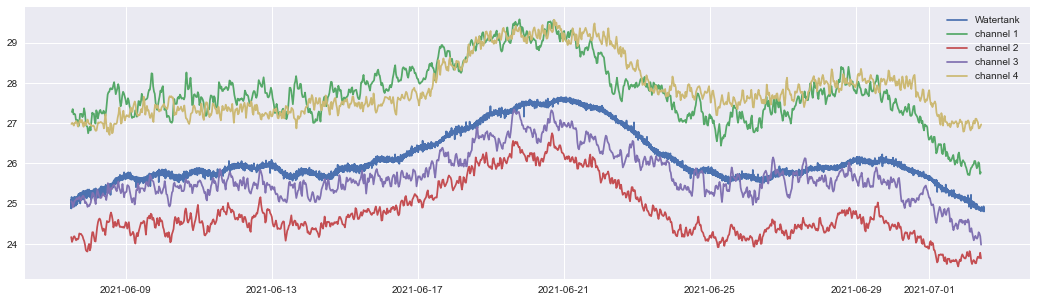

In [49]:
# Other channels
watertank = 69

plt.figure(figsize=(18,5))
position_watertank=15
plt.plot(df_Tlogger.index, df_Tlogger["Channel1-Watertank"], label="Watertank")
#plt.plot(df_Tlogger.index, df_Tlogger["Channel2-Air"], label="Air")
for c in ["1","2","3","4"]:
    inde=data_2021[c][str(df_Tlogger.index.min()) : str(df_Tlogger.index.max())][watertank].index
    val=data_2021[c][str(df_Tlogger.index.min()) : str(df_Tlogger.index.max())][watertank].values
    plt.plot(inde,val, label=f"channel {c}")
plt.legend()

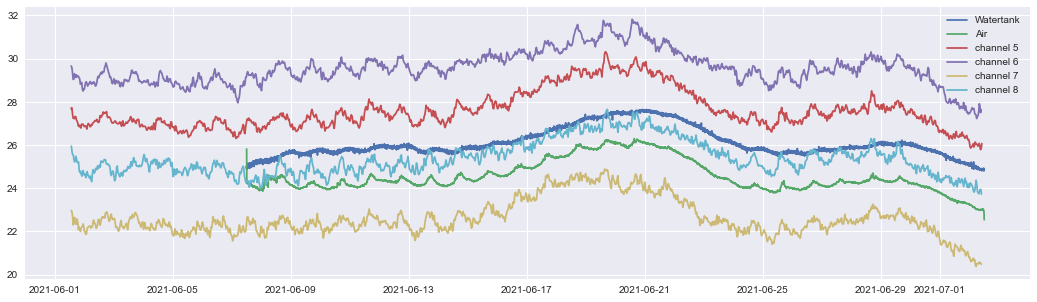

In [50]:
# Plot some data
plt.figure(figsize=(18,5))
length=10
plt.plot(df_Tlogger.index, df_Tlogger["Channel1-Watertank"], label="Watertank")
plt.plot(df_Tlogger.index, df_Tlogger["Channel2-Air"], label="Air")
for c in ["5","6","7","8"]:
    inde=data_2021[c][length].index
    val=data_2021[c][length].values
    plt.plot(inde,val, label=f"channel {c}")

plt.legend()

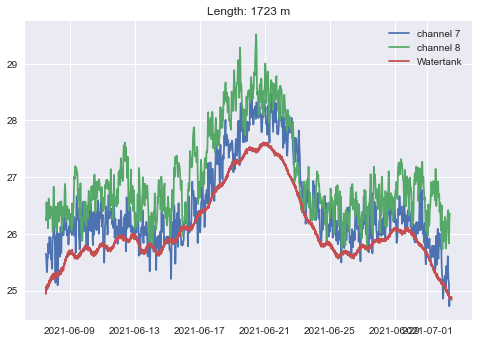

In [51]:
# take a closer look at 1723 #watertank_len
watertank=1723
plt.plot(corrected_val["7"].loc[:,watertank].index,corrected_val["7"].loc[:,watertank].values,label="channel 7")
plt.plot(corrected_val["8"].loc[:,watertank].index,corrected_val["8"].loc[:,watertank].values,label="channel 8")
plt.plot(df_Tlogger["Channel1-rolling_mean"].index,df_Tlogger["Channel1-rolling_mean"].values,label="Watertank")
plt.title(f"Length: {watertank} m")
plt.legend()

In [52]:
# # diff steigt mit länge des Kabels
# diff=np.abs(corrected_val["7"] - corrected_val["8"])
# diff_clean=np.delete(diff,np.where(diff > 6)) #remove outliers
# leng=len(diff_clean)
# x=np.arange(0,leng)

# plt.plot(x,diff_clean,label="diffs")
# a,b=np.polyfit(x,diff_clean,deg=1)

# plt.plot(x,b+a*x,label="linear fit")
# plt.legend()
# print(f"{a},    {b}")